# Projet 6

In [3]:
import random
import os
# notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk
from Package import Scripts_AnalyseMulti01 as pk_multi
from Package import Scripts_AnalyseMulti02_Unsupervised as pk_multi_unsp
from Package import Scripts_AnalyseMulti02_Supervised as pk_multi_sup
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from umap import UMAP
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
from sklearn import metrics
import gc
import time
from contextlib import contextmanager
import warnings
import numpy as np
from datetime import datetime
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from dotenv import load_dotenv
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
import spacy
import re
from nltk.stem.snowball import SnowballStemmer
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext pycodestyle_magic


In [4]:
from emot.emo_unicode import UNICODE_EMOJI as UNICODE_EMO# For emojis
from emot.emo_unicode import EMOTICONS_EMO# For EMOTICONS

In [5]:
from tqdm import tqdm,notebook
notebook.tqdm().pandas()

0it [00:00, ?it/s]

In [ ]:
%flake8_off

ValueError: Function <bound method VarWatcher.auto_run_flake8 of <pycodestyle_magic.VarWatcher object at 0x000001D27D0E53A0>> is not registered as a post_run_cell callback

In [5]:
# chargement des variables d'environnment
load_dotenv() 

Python-dotenv could not parse statement starting at line 1


True

# Collecte des données

Uniquement API ? Les fichiers json ?

In [6]:
api_key = os.getenv('API_KEY')
endpoint = "https://api.yelp.com/v3/graphql"

Réalisons une fonction pour réaliser des requêtes en GraphQL. On utilise cette solution afin de pouvoir collecter les informations uniquement des champs qui nous intéressent.

In [7]:
def request_client(api_key, endpoint, query):
    reqHeaders = {
        'Authorization': 'Bearer ' + api_key 
    }

    _transport = RequestsHTTPTransport(
        url=endpoint,
        headers = reqHeaders,
        use_json=True,
    )

    client = Client(
        transport = _transport,
        fetch_schema_from_transport=True,
    )

    result = client.execute(query)
    return result

In [8]:
# le max de review est de 3 par restaurant, on importe toutes les données
restaurants=[]
j = 0
for i in range(0,4):
    query = """
                {
                search(term:"restaurant",
                        location: "France",
                        limit:50,
                        offset:"""+str(j)+"""
                        ) {
                    business {
                    id,
                    name,
                    photos,
                    reviews{
                        id,
                        text,
                        rating
                    }
                    }
                }
                }
            """
    query = gql(query)
    temp = request_client(api_key, endpoint, query)["search"]["business"]
    restaurants.extend(temp)
    print("nb restaurants ", len(restaurants))
    j=j+51
    

nb restaurants  50
nb restaurants  100
nb restaurants  150
nb restaurants  200


In [659]:
restaurants = pd.DataFrame(restaurants)

In [660]:
restaurants.head(2)

id                           name  \
0  -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1  IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   

                                                                   photos  \
0  [https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg]   
1  [https://s3-media4.fl.yelpcdn.com/bphoto/J9RByC4HuTubBKX77PYeEg/o.jpg]   

                                                                                               reviews  
0  [{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My favorite meal in Paris! 

We started off with the ...  
1  [{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'This is a small bar/restaurant closed to Cathédrale N...

# Construction des bases de données

On scinde notre fichier en deux afin de traiter le texte et les photos séparément.

In [687]:
df = restaurants.copy()

In [688]:
df.head(2)

id                           name  \
0  -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1  IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   

                                                                   photos  \
0  [https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg]   
1  [https://s3-media4.fl.yelpcdn.com/bphoto/J9RByC4HuTubBKX77PYeEg/o.jpg]   

                                                                                               reviews  
0  [{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My favorite meal in Paris! 

We started off with the ...  
1  [{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'This is a small bar/restaurant closed to Cathédrale N...

In [689]:
df['reviews'].apply(pd.Series)[0].apply(pd.Series)

id  \
0    aGP7nLwEQOUg64jKP8ebsw   
1    -to6adg_kucf1SgQckgJXw   
2    WMRKQUUR3BmjV_EZg7zVfw   
3    un3pGCn6lKHDbaI-hsrk-A   
4    3u0PefxOlwysE22VZa9OSA   
..                      ...   
195  JIiCwKFnpBL76fOX79pwRg   
196  vs1Aeepu-UrpNZyTzaQxwg   
197  _pHOfFvvdLdeRpZ-OTnQoA   
198  bJNWq9qdikfH-l3t6P7xfA   
199  U05nUrtYO9-qixA3PanI7A   

                                                                                                    text  \
0    My favorite meal in Paris! \n\nWe started off with the foie gras carpaccio and escargot. Love th...   
1    This is a small bar/restaurant closed to Cathédrale Notre Dame. I always come here for lunch or ...   
2    this is for a review from 2019, this place is perfect. would recommend 100%. prices are great, f...   
3    When I visited Paris last week, I had stopped by here by a recommendation of a friend and also r...   
4    Based on some research, we decided to book a reservation here for a meal on our first night in P...   
..                                                                                                   ...   
195  Great service and excellent food! I highly recommend this quaint little restaurant. Be sure to s...   
196  One of the best breakfasts I've ever had. \nAnd that was just the start. \nThe location is great...   
197  Holy crap.  This place is a must do on your European fine dining bucket list.  Located at the fa...   
198  As a single female, this is a comfortable and friendly place to enjoy. I only had the appetizers...   
199  Absolutely, hands down the best meal I have ever had. My wife and I booked this dinner for our a...   

     rating  
0         5  
1         5  
2         5  
3         5  
4         5  
..      ...  
195       5  
196       5  
197       5  
198       5  
199       5  

[200 rows x 3 columns]

In [690]:
df

id                           name  \
0    -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1    IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   
2    WHHt_Jb8Tgidn9mW7oDnIg                 La Coïncidence   
3    cEjF41ZQB8-SST8cd3EsEw               L'Avant Comptoir   
4    ctP4c3mwVO5oOzLI48LtuQ                Les Antiquaires   
..                      ...                            ...   
195  4kfOSgh1GlUjcRCaYgDV8g                       Le Louis   
196  uSbrVw_sVHOthg63MwJBxA                      Zia Paris   
197  hiqQTVdbpcQtgCqu2M6PqQ                        Le Cinq   
198  3K6B3W9N4wUD7l3GT7YUsg                  Le Poulailler   
199  eoUCWArm9w8kXtyA0N7MoQ                          ASPIC   

                                                                     photos  \
0    [https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg]   
1    [https://s3-media4.fl.yelpcdn.com/bphoto/J9RByC4HuTubBKX77PYeEg/o.jpg]   
2    [https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgEgbd5TLlqZYT_dezg/o.jpg]   
3    [https://s3-media3.fl.yelpcdn.com/bphoto/mVwgxgmpUcAUOZKdxypwSw/o.jpg]   
4    [https://s3-media3.fl.yelpcdn.com/bphoto/aBwaSVkWWFKTGl1gM8N90g/o.jpg]   
..                                                                      ...   
195  [https://s3-media2.fl.yelpcdn.com/bphoto/zTG7LJ3ChQwZ-5rp4fF-dA/o.jpg]   
196  [https://s3-media2.fl.yelpcdn.com/bphoto/trP-Cj9pHYKE5VuaabP6jQ/o.jpg]   
197  [https://s3-media4.fl.yelpcdn.com/bphoto/hWCc8_pvL1X4hQ_hnz7gnQ/o.jpg]   
198  [https://s3-media2.fl.yelpcdn.com/bphoto/Q8VtWRo5vKlxLCzu8RhXsg/o.jpg]   
199  [https://s3-media2.fl.yelpcdn.com/bphoto/QQZtg7Ashz486V3CQ4AqnQ/o.jpg]   

                                                                                                 reviews  
0    [{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My favorite meal in Paris! 

We started off with the ...  
1    [{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'This is a small bar/restaurant closed to Cathédrale N...  
2    [{'id': 'WMRKQUUR3BmjV_EZg7zVfw', 'text': 'this is for a review from 2019, this place is perfect...  
3    [{'id': 'un3pGCn6lKHDbaI-hsrk-A', 'text': 'When I visited Paris last week, I had stopped by here...  
4    [{'id': '3u0PefxOlwysE22VZa9OSA', 'text': 'Based on some research, we decided to book a reservat...  
..                                                                                                   ...  
195  [{'id': 'JIiCwKFnpBL76fOX79pwRg', 'text': 'Great service and excellent food! I highly recommend ...  
196  [{'id': 'vs1Aeepu-UrpNZyTzaQxwg', 'text': 'One of the best breakfasts I've ever had. 
And that w...  
197  [{'id': '_pHOfFvvdLdeRpZ-OTnQoA', 'text': 'Holy crap.  This place is a must do on your European ...  
198  [{'id': 'bJNWq9qdikfH-l3t6P7xfA', 'text': 'As a single female, this is a comfortable and friendl...  
199  [{'id': 'U05nUrtYO9-qixA3PanI7A', 'text': 'Absolutely, hands down the best meal I have ever had....  

[200 rows x 4 columns]

In [691]:
df = pd.concat([df.drop(['reviews'], axis=1), 
    df['reviews'].apply(pd.Series)[0].apply(pd.Series)]
    , axis=1)


In [692]:
df.columns

Index(['id', 'name', 'photos', 'id', 'text', 'rating'], dtype='object')

In [693]:
df.columns = ['id', 'name', 'photos', 'rw_id', 'rw_text', 'rw_rating']

In [694]:
df.head(2)

id                           name  \
0    -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1    IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   
2    WHHt_Jb8Tgidn9mW7oDnIg                 La Coïncidence   
3    cEjF41ZQB8-SST8cd3EsEw               L'Avant Comptoir   
4    ctP4c3mwVO5oOzLI48LtuQ                Les Antiquaires   
..                      ...                            ...   
195  4kfOSgh1GlUjcRCaYgDV8g                       Le Louis   
196  uSbrVw_sVHOthg63MwJBxA                      Zia Paris   
197  hiqQTVdbpcQtgCqu2M6PqQ                        Le Cinq   
198  3K6B3W9N4wUD7l3GT7YUsg                  Le Poulailler   
199  eoUCWArm9w8kXtyA0N7MoQ                          ASPIC   

                                                                     photos  \
0    [https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg]   
1    [https://s3-media4.fl.yelpcdn.com/bphoto/J9RByC4HuTubBKX77PYeEg/o.jpg]   
2    [https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgEgbd5TLlqZYT_dezg/o.jpg]   
3    [https://s3-media3.fl.yelpcdn.com/bphoto/mVwgxgmpUcAUOZKdxypwSw/o.jpg]   
4    [https://s3-media3.fl.yelpcdn.com/bphoto/aBwaSVkWWFKTGl1gM8N90g/o.jpg]   
..                                                                      ...   
195  [https://s3-media2.fl.yelpcdn.com/bphoto/zTG7LJ3ChQwZ-5rp4fF-dA/o.jpg]   
196  [https://s3-media2.fl.yelpcdn.com/bphoto/trP-Cj9pHYKE5VuaabP6jQ/o.jpg]   
197  [https://s3-media4.fl.yelpcdn.com/bphoto/hWCc8_pvL1X4hQ_hnz7gnQ/o.jpg]   
198  [https://s3-media2.fl.yelpcdn.com/bphoto/Q8VtWRo5vKlxLCzu8RhXsg/o.jpg]   
199  [https://s3-media2.fl.yelpcdn.com/bphoto/QQZtg7Ashz486V3CQ4AqnQ/o.jpg]   

                      rw_id  \
0    aGP7nLwEQOUg64jKP8ebsw   
1    -to6adg_kucf1SgQckgJXw   
2    WMRKQUUR3BmjV_EZg7zVfw   
3    un3pGCn6lKHDbaI-hsrk-A   
4    3u0PefxOlwysE22VZa9OSA   
..                      ...   
195  JIiCwKFnpBL76fOX79pwRg   
196  vs1Aeepu-UrpNZyTzaQxwg   
197  _pHOfFvvdLdeRpZ-OTnQoA   
198  bJNWq9qdikfH-l3t6P7xfA   
199  U05nUrtYO9-qixA3PanI7A   

                                                                                                 rw_text  \
0    My favorite meal in Paris! \n\nWe started off with the foie gras carpaccio and escargot. Love th...   
1    This is a small bar/restaurant closed to Cathédrale Notre Dame. I always come here for lunch or ...   
2    this is for a review from 2019, this place is perfect. would recommend 100%. prices are great, f...   
3    When I visited Paris last week, I had stopped by here by a recommendation of a friend and also r...   
4    Based on some research, we decided to book a reservation here for a meal on our first night in P...   
..                                                                                                   ...   
195  Great service and excellent food! I highly recommend this quaint little restaurant. Be sure to s...   
196  One of the best breakfasts I've ever had. \nAnd that was just the start. \nThe location is great...   
197  Holy crap.  This place is a must do on your European fine dining bucket list.  Located at the fa...   
198  As a single female, this is a comfortable and friendly place to enjoy. I only had the appetizers...   
199  Absolutely, hands down the best meal I have ever had. My wife and I booked this dinner for our a...   

     rw_rating  
0            5  
1            5  
2            5  
3            5  
4            5  
..         ...  
195          5  
196          5  
197          5  
198          5  
199          5  

[200 rows x 6 columns]

Exportons les données en csv

In [695]:
df.to_csv('output/restaurants_v2.csv')

Requête pour importer les données.

In [696]:
df

id                           name  \
0    -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1    IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   
2    WHHt_Jb8Tgidn9mW7oDnIg                 La Coïncidence   
3    cEjF41ZQB8-SST8cd3EsEw               L'Avant Comptoir   
4    ctP4c3mwVO5oOzLI48LtuQ                Les Antiquaires   
..                      ...                            ...   
195  4kfOSgh1GlUjcRCaYgDV8g                       Le Louis   
196  uSbrVw_sVHOthg63MwJBxA                      Zia Paris   
197  hiqQTVdbpcQtgCqu2M6PqQ                        Le Cinq   
198  3K6B3W9N4wUD7l3GT7YUsg                  Le Poulailler   
199  eoUCWArm9w8kXtyA0N7MoQ                          ASPIC   

                                                                     photos  \
0    [https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg]   
1    [https://s3-media4.fl.yelpcdn.com/bphoto/J9RByC4HuTubBKX77PYeEg/o.jpg]   
2    [https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgEgbd5TLlqZYT_dezg/o.jpg]   
3    [https://s3-media3.fl.yelpcdn.com/bphoto/mVwgxgmpUcAUOZKdxypwSw/o.jpg]   
4    [https://s3-media3.fl.yelpcdn.com/bphoto/aBwaSVkWWFKTGl1gM8N90g/o.jpg]   
..                                                                      ...   
195  [https://s3-media2.fl.yelpcdn.com/bphoto/zTG7LJ3ChQwZ-5rp4fF-dA/o.jpg]   
196  [https://s3-media2.fl.yelpcdn.com/bphoto/trP-Cj9pHYKE5VuaabP6jQ/o.jpg]   
197  [https://s3-media4.fl.yelpcdn.com/bphoto/hWCc8_pvL1X4hQ_hnz7gnQ/o.jpg]   
198  [https://s3-media2.fl.yelpcdn.com/bphoto/Q8VtWRo5vKlxLCzu8RhXsg/o.jpg]   
199  [https://s3-media2.fl.yelpcdn.com/bphoto/QQZtg7Ashz486V3CQ4AqnQ/o.jpg]   

                      rw_id  \
0    aGP7nLwEQOUg64jKP8ebsw   
1    -to6adg_kucf1SgQckgJXw   
2    WMRKQUUR3BmjV_EZg7zVfw   
3    un3pGCn6lKHDbaI-hsrk-A   
4    3u0PefxOlwysE22VZa9OSA   
..                      ...   
195  JIiCwKFnpBL76fOX79pwRg   
196  vs1Aeepu-UrpNZyTzaQxwg   
197  _pHOfFvvdLdeRpZ-OTnQoA   
198  bJNWq9qdikfH-l3t6P7xfA   
199  U05nUrtYO9-qixA3PanI7A   

                                                                                                 rw_text  \
0    My favorite meal in Paris! \n\nWe started off with the foie gras carpaccio and escargot. Love th...   
1    This is a small bar/restaurant closed to Cathédrale Notre Dame. I always come here for lunch or ...   
2    this is for a review from 2019, this place is perfect. would recommend 100%. prices are great, f...   
3    When I visited Paris last week, I had stopped by here by a recommendation of a friend and also r...   
4    Based on some research, we decided to book a reservation here for a meal on our first night in P...   
..                                                                                                   ...   
195  Great service and excellent food! I highly recommend this quaint little restaurant. Be sure to s...   
196  One of the best breakfasts I've ever had. \nAnd that was just the start. \nThe location is great...   
197  Holy crap.  This place is a must do on your European fine dining bucket list.  Located at the fa...   
198  As a single female, this is a comfortable and friendly place to enjoy. I only had the appetizers...   
199  Absolutely, hands down the best meal I have ever had. My wife and I booked this dinner for our a...   

     rw_rating  
0            5  
1            5  
2            5  
3            5  
4            5  
..         ...  
195          5  
196          5  
197          5  
198          5  
199          5  

[200 rows x 6 columns]

In [4]:
df = pd.read_csv('output/restaurants_v2.csv')

In [5]:
df.head(2)
#del df["Unnamed: 0"]

Unnamed: 0                      id                           name  \
0           0  -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1           1  IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   

                                              photos                   rw_id  \
0  ['https://s3-media2.fl.yelpcdn.com/bphoto/TtMQ...  aGP7nLwEQOUg64jKP8ebsw   
1  ['https://s3-media4.fl.yelpcdn.com/bphoto/J9RB...  -to6adg_kucf1SgQckgJXw   

                                             rw_text  rw_rating  
0  My favorite meal in Paris! \n\nWe started off ...          5  
1  This is a small bar/restaurant closed to Cathé...          5

Complète les données avec les fichiers json + photos à télécharger

In [6]:
filename = "input\yelp_dataset\yelp_academic_dataset_review.json"
reviews_json = pd.read_json(filename, lines=True, nrows=300000)

In [18]:
del reviews_json

In [6]:
#reviews_json = reviews_json.loc[reviews_json["stars"]<=1]

In [7]:
reviews_json.head(2)

review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   

                                                text                date  
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18

In [8]:
reviews_json.shape

(300000, 9)

In [9]:
reviews_json[['review_id', 'business_id']].duplicated().sum()

0

In [7]:
filename = "input\yelp_dataset\yelp_academic_dataset_business.json"
bs_json = pd.read_json(filename, lines=True)

In [61]:
bs_json

business_id                      name  \
0       Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1       mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2       tUFrWirKiKi_TAnsVWINQQ                    Target   
3       MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4       mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   
...                        ...                       ...   
150341  IUQopTMmYQG-qRtBk-8QnA              Binh's Nails   
150342  c8GjPIOTGVmIemT7j5_SyQ      Wild Birds Unlimited   
150343  _QAMST-NrQobXduilWEqSw         Claire's Boutique   
150344  mtGm22y5c2UHNXDFAjaPNw  Cyclery & Fitness Center   
150345  jV_XOycEzSlTx-65W906pg                   Sic Ink   

                                address           city state postal_code  \
0                1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1       87 Grasso Plaza Shopping Center         Affton    MO       63123   
2                  5255 E Broadway Blvd         Tucson    AZ       85711   
3                           935 Race St   Philadelphia    PA       19107   
4                         101 Walnut St     Green Lane    PA       18054   
...                                 ...            ...   ...         ...   
150341                3388 Gateway Blvd       Edmonton    AB     T6J 5H2   
150342               2813 Bransford Ave      Nashville    TN       37204   
150343           6020 E 82nd St, Ste 46   Indianapolis    IN       46250   
150344                     2472 Troy Rd   Edwardsville    IL       62025   
150345            238 Apollo Beach Blvd   Apollo beach    FL       33572   

         latitude   longitude  stars  review_count  is_open  \
0       34.426679 -119.711197    5.0             7        0   
1       38.551126  -90.335695    3.0            15        1   
2       32.223236 -110.880452    3.5            22        0   
3       39.955505  -75.155564    4.0            80        1   
4       40.338183  -75.471659    4.5            13        1   
...           ...         ...    ...           ...      ...   
150341  53.468419 -113.492054    3.0            13        1   
150342  36.115118  -86.766925    4.0             5        1   
150343  39.908707  -86.065088    3.5             8        1   
150344  38.782351  -89.950558    4.0            24        1   
150345  27.771002  -82.394910    4.5             9        1   

                                               attributes  \
0                           {'ByAppointmentOnly': 'True'}   
1                  {'BusinessAcceptsCreditCards': 'True'}   
2       {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3       {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4       {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   
...                                                   ...   
150341  {'ByAppointmentOnly': 'False', 'RestaurantsPri...   
150342  {'BusinessAcceptsCreditCards': 'True', 'Restau...   
150343  {'RestaurantsPriceRange2': '1', 'BusinessAccep...   
150344  {'BusinessParking': '{'garage': False, 'street...   
150345  {'WheelchairAccessible': 'True', 'BusinessAcce...   

                                               categories  \
0       Doctors, Traditional Chinese Medicine, Naturop...   
1       Shipping Centers, Local Services, Notaries, Ma...   
2       Department Stores, Shopping, Fashion, Home & G...   
3       Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                               Brewpubs, Breweries, Food   
...                                                   ...   
150341                         Nail Salons, Beauty & Spas   
150342  Pets, Nurseries & Gardening, Pet Stores, Hobby...   
150343  Shopping, Jewelry, Piercing, Toy Stores, Beaut...   
150344  Fitness/Exercise Equipment, Eyewear & Optician...   
150345  Beauty & Spas, Permanent Makeup, Piercing, Tattoo   

                                                    hours  
0                                                    None  
1       {'Monday': '0:0-0:0', 'Tuesday': '

In [11]:
bs_json[['business_id']].duplicated().sum()

0

In [54]:
bs_json.head(2)

NameError: name 'bs_json' is not defined

In [8]:
gc.collect()

0

In [13]:
bs_json = bs_json[["business_id", "name", "is_open"]].loc[bs_json["is_open"]==1]

On fait une jointure pour récupérer le nom du restaurant.

In [14]:
df_json = reviews_json.merge(bs_json, how="inner", on="business_id")

In [15]:
df_json.head(2)

review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  VJxlBnJmCDIy8DFG0kjSow  Iaee7y6zdSB3B-kRCo4z1w  XQfwVwDr-v0ZS3_CbbE5Xw   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      2       0      0     0   

                                                text                date  \
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11   
1  This is the second time we tried turning point... 2017-05-13 17:06:55   

                           name  is_open  
0  Turning Point of North Wales        1  
1  Turning Point of North Wales        1

Nous filtrons pour obtenir les mêmes colonnes que l'API.

In [16]:
reviews_json_filt = df_json[["review_id", "stars", "text"]]
reviews_json_filt.columns = ["rw_id", "rw_rating", "rw_text"]

In [17]:
reviews_json_filt

rw_id  rw_rating  \
0       KU_O5udG6zpxOg-VcAEodg          3   
1       VJxlBnJmCDIy8DFG0kjSow          2   
2       S6pQZQocMB1WHMjTRbt77A          4   
3       WqgTKVqWVHDHjnjEsBvUgg          3   
4       M0wzFFb7pefOPcxeRVbLag          2   
...                        ...        ...   
230483  bOwjKkyoRo7akW2LW_IqiQ          5   
230484  ucabNKXRq4JpfvaGnjPFhA          5   
230485  PuAOrscBb1ImGxnZH4HcUA          5   
230486  f9uHb7MnxukGlE17c6-TFA          5   
230487  RA9Ov3Cx3ZYFrCc19pv_fQ          1   

                                                  rw_text  
0       If you decide to eat here, just be aware it is...  
1       This is the second time we tried turning point...  
2       The place is cute and the staff was very frien...  
3       We came on a Saturday morning after waiting a ...  
4       Mediocre at best. The decor is very nice, and ...  
...                                                   ...  
230483  Very helpful, professional, well spoken and fr...  
230484  I was dreading putting our home on the market ...  
230485  My son just started at Kiddie Academy (I switc...  
230486  Been to this location numerous times. Always a...  
230487  I hope this will help others who have a chance...  

[230488 rows x 3 columns]

In [18]:
reviews = df[["rw_id", "rw_rating", "rw_text"]].copy()

In [19]:
reviews_ct = pd.concat([reviews, reviews_json_filt])


In [20]:
sum(reviews_ct.duplicated())

0

In [21]:
reviews_ct["rw_rating"].unique()

array([5, 4, 3, 1, 2], dtype=int64)

In [22]:
reviews = reviews_ct.copy()

In [72]:
filename = "input\yelp_photos\photos.json"
photos_json = pd.read_json(filename, lines=True, nrows=2000)

In [6]:
photos_json

photo_id             business_id  \
0    zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1    HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2    vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3    pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4    H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   
..                      ...                     ...   
195  UVO6t1mMaK_HLCduAR62OA  Bh5BlGuDzAMUeK7JKT5lfw   
196  jmhQ-MNlLKh1u1xoZD_M5A  4n22rhH6sdrAWHm54datEA   
197  6JVJTMuUENGHg1uewkIxoA  9mO8g03EPrrB2hg_log1cQ   
198  KJ5onXgXPn55XLlIQ7s6Yg  S1FwTmCAwv5ulu5gToWi_w   
199  TzxhwK7YuVMVyu-p3QKPKA  jN5vIPSJsWt7O9NL9lZY3w   

                                               caption    label  
0    Nice rock artwork everywhere and craploads of ...   inside  
1                                                       outside  
2                                       oyster shooter    drink  
3                                        Shrimp scampi     food  
4                                                          food  
..                                                 ...      ...  
195                          vegetarian baja flatbread     food  
196  Cashew nut chicken side of white rice and jasm...     food  
197                                                        food  
198                                                       drink  
199                                                        food  

[200 rows x 4 columns]

In [23]:
photos = df[["id", "photos"]]

# Analyse des données

## Pré traitement des données textuelles

Analysons le texte en premier lieu

Regardons le nombre de commentaire par note. Traçons un diagramme en barre

In [12]:
pk.graph_barplot(reviews['rw_rating'],
                  "Répartition des commentaires en fonction des notes", 
                   (0.564, 0.823, 0.631),
                   0, 60, "Note", "Fréquence en %",70, 1, (14,8))

NameError: name 'reviews' is not defined

In [23]:
reviews['rw_rating'].describe()

count    401120.000000
mean          3.856938
std           1.409803
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rw_rating, dtype: float64

Le but est de découvrir les sujets insatisfaisants, nous commençons par compter le nombre de mots.

In [24]:
reviews

rw_id  rw_rating  \
0       aGP7nLwEQOUg64jKP8ebsw          5   
1       -to6adg_kucf1SgQckgJXw          5   
2       WMRKQUUR3BmjV_EZg7zVfw          5   
3       un3pGCn6lKHDbaI-hsrk-A          5   
4       3u0PefxOlwysE22VZa9OSA          5   
...                        ...        ...   
400915  bOrQZsNrbd966S4oOq1O5g          5   
400916  kesW3gdryYmHjGfxv_Wx0A          5   
400917  NAwPTlX471lFle06AYt_NA          1   
400918  nyU8UUgC8WbZA1CY2Gqrvw          1   
400919  xYwuu9eRPZiulLgYCXpJ6w          5   

                                                  rw_text  
0       My favorite meal in Paris! \n\nWe started off ...  
1       This is a small bar/restaurant closed to Cathé...  
2       this is for a review from 2019, this place is ...  
3       When I visited Paris last week, I had stopped ...  
4       Based on some research, we decided to book a r...  
...                                                   ...  
400915  Stopped in because I love this chain of stores...  
400916  Awesome company. Needed some maintenance on a ...  
400917  I was planning on going into Music City Golf a...  
400918  I don't recommend this place because they sell...  
400919  Back in town for the holidays and needed to fi...  

[401120 rows x 3 columns]

In [25]:
reviews["rw_text"]

0         My favorite meal in Paris! \n\nWe started off ...
1         This is a small bar/restaurant closed to Cathé...
2         this is for a review from 2019, this place is ...
3         When I visited Paris last week, I had stopped ...
4         Based on some research, we decided to book a r...
                                ...                        
400915    Stopped in because I love this chain of stores...
400916    Awesome company. Needed some maintenance on a ...
400917    I was planning on going into Music City Golf a...
400918    I don't recommend this place because they sell...
400919    Back in town for the holidays and needed to fi...
Name: rw_text, Length: 401120, dtype: object

Nous observons des retours à la ligne "\n" et la présence de ponctuation dans le texte. Il faut donc supprimer ces caractères. Cependant, il faut faire attention car il se peut qu'il y ait des smileys.
Créons une fonction pour traiter le texte.

In [20]:
from unidecode import unidecode

In [7]:
unidecode("holà como estàs y èfezhfezé&")

'hola como estas y efezhfeze&'

In [21]:
def text_cleaning(text, ponct, only_letters, numbers):
    text = text.lower()
    text = unidecode(text)
    ponctuation = "[^!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]"
    number = "[^0-9]"
    letters = "[^a-zA-Z ]"
    if ponct == 1:
        text = re.sub(ponctuation, '', text)
    if only_letters == 1:
        text = re.sub(letters, '', text)
    if numbers == 1:
        text = re.sub(number, '', text)
    return text

In [10]:
# Function for converting emojis into word
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text# Example


In [11]:
text1 = "Hilarious :) 😂. The feeling of making a sale 😎, The feeling of actually fulfilling orders 😒"
convert_emojis(text1)

'Hilarious :) face_with_tears_of_joy. The feeling of making a sale smiling_face_with_sunglasses, The feeling of actually fulfilling orders unamused_face'

In [11]:
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, EMOTICONS_EMO[emot].replace(" ","_"))
    return text


text = "Hello :-) :-)"
convert_emoticons(text)

'Hello Happy_face_smiley Happy_face_smiley'

Réécrivons les contractions en entier.

In [12]:
import contractions

test = contractions.fix("shouldn't")
test

'should not'

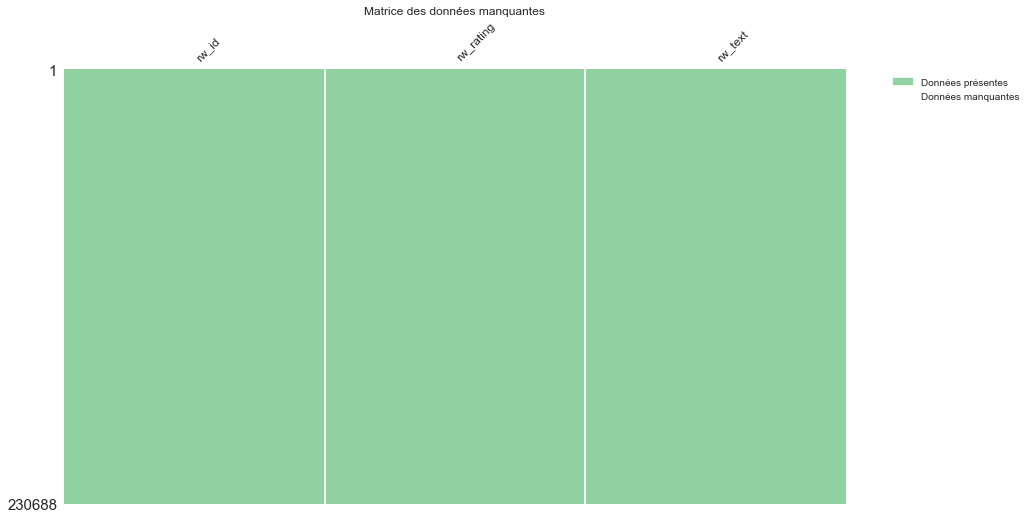

In [30]:
#pk.data_missingTab(reviews)
pk.matrix_vm(reviews, (14,8), (0.564, 0.823, 0.631))

In [13]:
gc.collect()

771

In [31]:
reviews["rw_text"] = reviews["rw_text"].str.lower()

In [32]:
reviews['rw_text'] = reviews.progress_apply(lambda x: convert_emojis(x['rw_text']),axis=1)

C:\Users\aurel\AppData\Local\Temp\ipykernel_20996\653643110.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

  0%|          | 0/230688 [00:00<?, ?it/s]

In [33]:
reviews['rw_text'] = reviews.progress_apply(lambda x: convert_emoticons(x['rw_text']),axis=1)

  0%|          | 0/230688 [00:00<?, ?it/s]

In [34]:
gc.collect()

64

In [35]:
reviews['rw_text'] = reviews.progress_apply(lambda x: contractions.fix(x['rw_text']),axis=1)

  0%|          | 0/230688 [00:00<?, ?it/s]

In [36]:
gc.collect()

18

In [37]:
reviews['rw_text'] = reviews.progress_apply(lambda x: text_cleaning(x['rw_text'], 0, 1, 0),axis=1)

  0%|          | 0/230688 [00:00<?, ?it/s]

In [38]:
gc.collect()

18

In [42]:
import dill
dill.dump_session('notebook_env.db')

In [41]:
reviews['words'] = reviews.progress_apply(lambda x: word_tokenize(x['rw_text']),axis=1)

  0%|          | 0/230688 [00:00<?, ?it/s]

In [ ]:
gc.collect()

18

In [5]:
import dill
dill.load_session('notebook_env.db')

In [6]:
reviews['nb_words'] = reviews.progress_apply(lambda x: len(x['words']),axis=1)

  0%|          | 0/230688 [00:00<?, ?it/s]

In [9]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                               words  nb_words  
0  [my, favorite, meal, in, paris, we, started, o...        28  
1  [this, is, a, small, barrestaurant, closed, to...        29

In [40]:
graph = reviews.sort_values(by='nb_words', ascending=False)
pk.graph_intv_bar(graph, 'rw_id', 'nb_words', "rw_id", "nb words", 'redor', "Nombre de mots par commentaire")

KeyboardInterrupt: 

In [ ]:
reviews["nb_words"].describe()

Nous avons en moyenne 101.03 mots par commentaire. Et 50% des commentaires font plus de 72 mots.

Regardons les mots les plus fréquents

In [43]:
words = nltk.tokenize.word_tokenize(" ".join(reviews['rw_text']))

In [51]:
word_dist = nltk.FreqDist(words)



In [44]:
gc.collect()

18

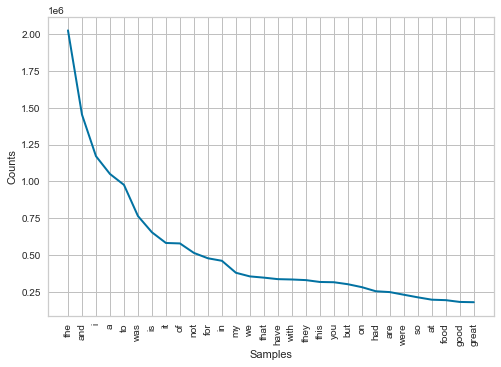

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [53]:
fdist = nltk.FreqDist(words)
fdist.plot(30)

Nous observons qu'il y a des déterminants de type : the, in, a qui sont très fréquent.
Nous devons supprimer ces mots car il n'apporte pas d'informations sur le sujet ou le sentiment du commentaire.

Réalisons une fonction pour compter le nombre de mot et faire le graphique

In [44]:
def nb_most_frequent_plt(df_var):
    words = nltk.tokenize.word_tokenize(" ".join(df_var))
    fdist = nltk.FreqDist(words)
    fdist.plot(30)

In [45]:
gc.collect()

18

Essayons d'utiliser la bibliothèque nltk

In [7]:
from nltk.corpus import stopwords
nltk.download('stopwords')

sw_nltk = stopwords.words('english')
print(sw_nltk)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dans la liste stopwords du package, il y a des mots qui sont importants pour l'identification des sentiments comme "very" ou les négations ("not"...).
Supprimons ces éléments de la liste de stopwords. De plus, le package supprime certains verbes comme be et have. Nous voulons garder ces verbes pour l'analyse de sentiment.

In [8]:
keep_words = ['not', 'but', 'if', 'because', 'against', 'between', 
              'during', 'before', 'after', 'again', 'more', 'most', 
              'such', 'only', 'own', 'same', 'than', 'too', 'very']
new_sw_nltk = [word for word in sw_nltk if word not in keep_words]

new_sw_nltk.extend(['th','pm', 's', 'er', 'paris', 'rst', 'st', 'am'])

Ces mots n'apportent pas de sens concernant les sentiments dans les phrases. Autrement dit, ce sont des mots dit vides pour notre projet.

In [9]:
pat = r'\b(?:{})\b'.format('|'.join(new_sw_nltk))
cleaning = reviews['rw_text'].str.replace(pat, '')
reviews['new_words'] = cleaning.progress_apply(lambda x: nltk.word_tokenize(x))
reviews['new_text'] = cleaning



  0%|          | 0/230688 [00:00<?, ?it/s]

In [10]:
import dill
dill.dump_session('notebook_env_2.db')

In [49]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                               words  nb_words  \
0  [my, favorite, meal, in, paris, we, started, o...        28   
1  [this, is, a, small, barrestaurant, closed, to...        29   

                                           new_words  \
0  [favorite, meal, started, foie, gras, carpacci...   
1  [small, barrestaurant, closed, cathedrale, not...   

                                            new_text  
0   favorite meal    started    foie gras carpacc...  
1     small barrestaurant closed  cathedrale notr...

In [ ]:
import dill
dill.load_session('notebook_env_2.db')

Etudions à nouveau les mots les plus fréquents.

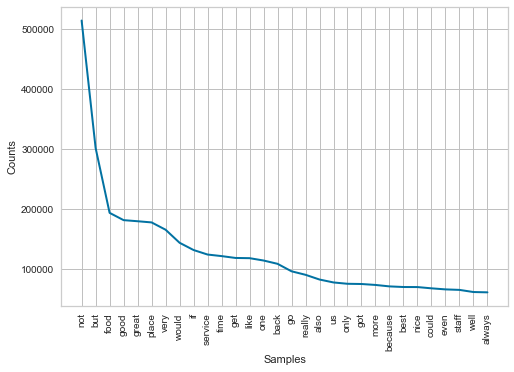

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [60]:
words = nltk.tokenize.word_tokenize(" ".join(reviews["new_text"]))
fdist = nltk.FreqDist(words)
fdist.plot(30)

Nous n'avons plus de mots dit vides. Il nous faut à présent conserver la racine des mots.
Il existe deux méthodes : Stemming et lemmatization.
Stemming supprime les suffixes et les préfixes des mots sans prendre en considération le contexte. 
Contrairement à la méthode stemming, la méthode lemmatization considère le contexte et convertit le mot dans sa forme de base "significative".

In [62]:
reviews.head(2)

rw_id  rw_rating  \
0       aGP7nLwEQOUg64jKP8ebsw          5   
1       -to6adg_kucf1SgQckgJXw          5   
2       WMRKQUUR3BmjV_EZg7zVfw          5   
3       un3pGCn6lKHDbaI-hsrk-A          5   
4       3u0PefxOlwysE22VZa9OSA          5   
...                        ...        ...   
400915  bOrQZsNrbd966S4oOq1O5g          5   
400916  kesW3gdryYmHjGfxv_Wx0A          5   
400917  NAwPTlX471lFle06AYt_NA          1   
400918  nyU8UUgC8WbZA1CY2Gqrvw          1   
400919  xYwuu9eRPZiulLgYCXpJ6w          5   

                                                  rw_text  \
0       my favorite meal in paris we started off with ...   
1       this is a small barrestaurant closed to cathed...   
2       this is for a review from  this place is perfe...   
3       when i visited paris last week i had stopped b...   
4       based on some research we decided to book a re...   
...                                                   ...   
400915  stopped in because i love this chain of stores...   
400916  awesome company needed some maintenance on a w...   
400917  i was planning on going into music city golf a...   
400918  i do not recommend this place because they sel...   
400919  back in town for the holidays and needed to fi...   

                                                    words  nb_words  \
0       [my, favorite, meal, in, paris, we, started, o...        28   
1       [this, is, a, small, barrestaurant, closed, to...        29   
2       [this, is, for, a, review, from, this, place, ...        22   
3       [when, i, visited, paris, last, week, i, had, ...        29   
4       [based, on, some, research, we, decided, to, b...        27   
...                                                   ...       ...   
400915  [stopped, in, because, i, love, this, chain, o...       137   
400916  [awesome, company, needed, some, maintenance, ...        77   
400917  [i, was, planning, on, going, into, music, cit...       211   
400918  [i, do, not, recommend, this, place, because, ...        88   
400919  [back, in, town, for, the, holidays, and, need...        64   

                                                new_words  \
0       [favorite, meal, started, foie, gras, carpacci...   
1       [small, barrestaurant, closed, cathedrale, not...   
2       [review, place, perfect, would, recommend, pri...   
3       [visited, last, week, stopped, recommendation,...   
4       [based, research, decided, book, reservation, ...   
...                                                   ...   
400915  [stopped, because, love, chain, stores, stop, ...   
400916  [awesome, company, needed, maintenance, water,...   
400917  [planning, going, music, city, golf, buying, n...   
400918  [not, recommend, place, because, sell, fake, t...   
400919  [back, town, holidays, needed, find, new, plac...   

                                                 new_text  
0        favorite meal    started    foie gras carpacc...  
1          small barrestaurant closed  cathedrale notr...  
2           review    place  perfect would recommend  ...  
3         visited  last week   stopped     recommendat...  
4       based   research  decided  book  reservation  ...  
...                                                   ...  
400915  stopped  because  love  chain  stores  stop   ...  
400916  awesome company needed  maintenance   water he...  
400917    planning  going  music city golf  buying  ne...  
400918    not recommend  place because  sell fake thin...  
400919  back  town   holidays  needed  find  new place...  

[401120 rows x 7 columns]

Nous pouvons supprimer les colonnes inutiles

In [11]:
del reviews["nb_words"]

In [12]:
reviews = reviews.drop(["new_words", "words"], axis=1)

In [54]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  
0   favorite meal    started    foie gras carpacc...  
1     small barrestaurant closed  cathedrale notr...

Ajoutons des tags pour connaitre la nature de chaque mot.

In [13]:
gc.collect()

17

In [14]:
def word_pos_tagger(list_words):
    pos_tagged_text = nltk.pos_tag(list_words)
    return pos_tagged_text

In [ ]:
reviews.shape

In [15]:
all_reviews = reviews["new_text"].str.cat(sep=' ')

In [5]:
all_reviews.head(2)

NameError: name 'all_reviews' is not defined

In [16]:
description_words = word_pos_tagger(nltk.word_tokenize(all_reviews))

In [636]:
description_words

[('favorite', 'JJ'),
 ('meal', 'NN'),
 ('started', 'VBD'),
 ('foie', 'JJ'),
 ('gras', 'NNS'),
 ('carpaccio', 'VBP'),
 ('escargot', 'RB'),
 ('love', 'VB'),
 ('unique', 'JJ'),
 ('way', 'NN'),
 ('foie', 'NN'),
 ('gras', 'NN'),
 ('was', 'VBD'),
 ('prepared', 'VBN'),
 ('thinly', 'RB'),
 ('is', 'VBZ'),
 ('small', 'JJ'),
 ('barrestaurant', 'NN'),
 ('closed', 'VBD'),
 ('cathdrale', 'NN'),
 ('notre', 'NN'),
 ('dame', 'NN'),
 ('always', 'RB'),
 ('come', 'VBN'),
 ('lunch', 'NN'),
 ('dinner', 'NN'),
 ('if', 'IN'),
 ('close', 'JJ'),
 ('hostess', 'NN'),
 ('is', 'VBZ'),
 ('very', 'RB'),
 ('friendly', 'JJ'),
 ('is', 'VBZ'),
 ('review', 'JJ'),
 ('place', 'NN'),
 ('is', 'VBZ'),
 ('perfect', 'JJ'),
 ('would', 'MD'),
 ('recommend', 'VB'),
 ('prices', 'NNS'),
 ('are', 'VBP'),
 ('great', 'JJ'),
 ('food', 'NN'),
 ('is', 'VBZ'),
 ('astoundingand', 'RB'),
 ('never', 'RB'),
 ('leave', 'VBP'),
 ('reviews', 'NNS'),
 ('michelin', 'NNS'),
 ('starred', 'VBD'),
 ('reservations', 'NNS'),
 ('weeks', 'NNS'),
 ('advance'

In [57]:
tag_fd = nltk.FreqDist(tag for (word, tag) in description_words)

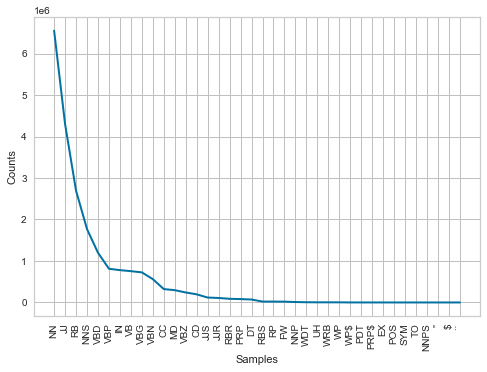

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [58]:
tag_fd.plot()

UH = interjection (expression affective > ha, oh)
EX = existentiel (ex : il y a)
WDT = wh-déterminant (ex : qui)
pour plus d'informations, voir : https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/

On exclut : IN, DT, CD, CC, RP, WDT, EX, MD, NNP, WDT, UH, WRB, 
WP, WP$, PDT, PRP$, EX, POS, SYM, TO, NNPS


In [640]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw        5.0   
1  -to6adg_kucf1SgQckgJXw        5.0   

                                                                                               rw_text  \
0  my favorite meal in paris we started off with the foie gras carpaccio and escargot love the uniq...   
1  this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or din...   

                                                                                              new_text  \
0   favorite meal    started    foie gras carpaccio  escargot love  unique way   foie gras was prep...   
1   is  small barrestaurant closed  cathdrale notre dame  always come   lunch  dinner if   close   ...   

                                                                                               stemmed  \
0             favorit meal start foie gras carpaccio escargot love uniqu way foie gras was prepar thin   
1  is small barrestaur close cathdral notr dame alway come lunch dinner if close hostess is veri fr...   

                                                                                            lemmatized  
0      favorite meal started foie gras carpaccio escargot love unique way foie gras wa prepared thinly  
1  is small barrestaurant closed cathdrale notre dame always come lunch dinner if close hostess is ...

In [17]:
list_keep = []
list_excl = ['IN', 'DT', 'CD', 'CC', 'RP', 'WDT', 'EX', 'MD', 'NNP', 'WDT', 'UH', 'WRB', 
'WP', 'WP$', 'PDT', 'PRP$', 'EX', 'POS', 'SYM', 'TO', 'NNPS']
for word, tag in description_words:
    if tag not in list_excl:
        list_keep.append(tag)

In [ ]:
gc.collect()

1650

In [ ]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  
0   favorite meal    started    foie gras carpacc...  
1     small barrestaurant closed  cathedrale notr...

In [18]:
import dill
dill.dump_session('notebook_env.db')

In [19]:
reviews["text_tokens_pos_tagged"] =  reviews["new_text"].progress_apply(lambda x: nltk.word_tokenize(x))

  0%|          | 0/230688 [00:00<?, ?it/s]

In [20]:
gc.collect()

18

In [21]:
reviews["text_tokens_pos_tagged"] =  reviews["text_tokens_pos_tagged"].progress_apply(lambda x: nltk.pos_tag(x))

  0%|          | 0/230688 [00:00<?, ?it/s]

In [22]:
gc.collect()

34

In [23]:
list_keep = set(list_keep)

In [24]:
list_keep = list(list_keep)

In [25]:
reviews["text_tagged_nn_vb"] =  reviews["text_tokens_pos_tagged"].progress_apply(lambda x: [y for y, tag in x if tag in list_keep])

  0%|          | 0/230688 [00:00<?, ?it/s]

In [26]:
list_nouns = ["NN", "NNS"]

reviews["words_subjects"] =  reviews["text_tokens_pos_tagged"].progress_apply(lambda x: [y for y, tag in x if tag in list_nouns])


  0%|          | 0/230688 [00:00<?, ?it/s]

In [27]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  \
0   favorite meal    started    foie gras carpacc...   
1     small barrestaurant closed  cathedrale notr...   

                              text_tokens_pos_tagged  \
0  [(favorite, JJ), (meal, NN), (started, VBD), (...   
1  [(small, JJ), (barrestaurant, NN), (closed, VB...   

                                   text_tagged_nn_vb  \
0  [favorite, meal, started, foie, gras, carpacci...   
1  [small, barrestaurant, closed, cathedrale, not...   

                                      words_subjects  
0                            [meal, gras, way, gras]  
1  [barrestaurant, cathedrale, notre, dame, lunch...

In [28]:
reviews["words_subjects"] =  reviews["words_subjects"].progress_apply(lambda x: " ".join(x))


  0%|          | 0/230688 [00:00<?, ?it/s]

In [29]:
reviews["text_tagged_nn_vb"] =  reviews["text_tagged_nn_vb"].progress_apply(lambda x: " ".join(x))


  0%|          | 0/230688 [00:00<?, ?it/s]

Concernant le traitement des sujets d'insatisfaction, il serait aussi intéressant de conserver la racine des mots après avoir filtrer sur les noms.
Il existe deux méthodes : Stemming et lemmatization.
Stemming supprime les suffixes et les préfixes des mots sans prendre en considération le contexte. 
Contrairement à la méthode stemming, la méthode lemmatization considère le contexte et convertit le mot dans sa forme de base "significative".

In [30]:
def stemming_text(word):
    stemmer = SnowballStemmer(language='english')
    return stemmer.stem(word)
 
def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return lemmatizer.lemmatize(text)

In [31]:
stemming_text("running")

'run'

In [32]:

lemmatize_text("runs")

'run'

In [34]:
reviews.shape

(230688, 7)

In [35]:
def short_words(text, lem_stem, new_var, var_to_convert):
    if lem_stem == 1: 
        stemmer = SnowballStemmer(language='english')
        reviews[new_var] = reviews[var_to_convert].progress_apply(lambda x: " ".join([stemmer.stem(y) for y in x]))
    if lem_stem == 2:
        reviews[new_var] = reviews[var_to_convert].progress_apply(lambda x: " ".join([lemmatize_text(y) for y in x]))


In [36]:
gc.collect()

7

In [37]:
reviews["words_subjects_st"] = reviews["words_subjects"].progress_apply(lambda x: stemming_text(x))

  0%|          | 0/230688 [00:00<?, ?it/s]

In [38]:
reviews["words_subjects_lem"] = reviews["words_subjects"].progress_apply(lambda x: lemmatize_text(x))

  0%|          | 0/230688 [00:00<?, ?it/s]

In [39]:
reviews["text_tagged_nn_vb_st"] =  reviews["text_tagged_nn_vb"].progress_apply(lambda x: stemming_text(x))


  0%|          | 0/230688 [00:00<?, ?it/s]

In [40]:
reviews["text_tagged_nn_vb_lem"] =  reviews["text_tagged_nn_vb"].progress_apply(lambda x: lemmatize_text(x))


  0%|          | 0/230688 [00:00<?, ?it/s]

In [41]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  \
0   favorite meal    started    foie gras carpacc...   
1     small barrestaurant closed  cathedrale notr...   

                              text_tokens_pos_tagged  \
0  [(favorite, JJ), (meal, NN), (started, VBD), (...   
1  [(small, JJ), (barrestaurant, NN), (closed, VB...   

                                   text_tagged_nn_vb  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                     words_subjects  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                words_subjects_st  \
0                               meal gras way gra   
1  barrestaurant cathedrale notre dame lunch dinn   

                                 words_subjects_lem  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                text_tagged_nn_vb_st  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                               text_tagged_nn_vb_lem  
0  favorite meal started foie gras carpaccio esca...  
1  small barrestaurant closed cathedrale notre da...

Regardons les mots les plus fréquents pour chaque méthode

In [6]:
gc.collect()

561

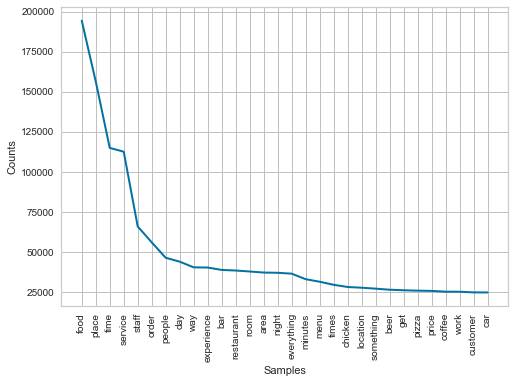

In [116]:
nb_most_frequent_plt(reviews["words_subjects_st"])

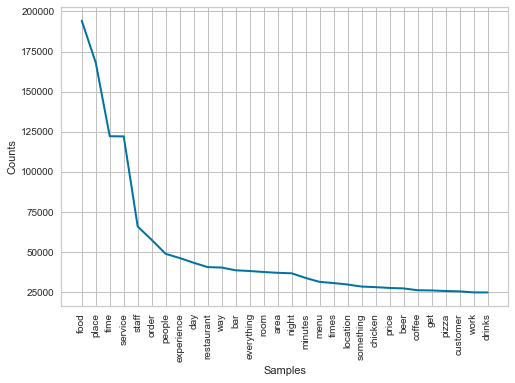

In [117]:

nb_most_frequent_plt(reviews["words_subjects_lem"])

Nous utilisons Vader pour obtenir les impressions de sentiments des couples de mots(positif, neutre, negatif).

Créons une fonction pour obtenir des informations sur les sentiments des groupes de mots.

In [43]:
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    return sentiment_dict

In [44]:
reviews["text_nn_vb_lem_feels"] = reviews["text_tagged_nn_vb_lem"].progress_apply(lambda x: sentiment_scores(x))

  0%|          | 0/230688 [00:00<?, ?it/s]

In [45]:
import dill
dill.dump_session('notebook_env_2.db')

In [7]:
reviews.shape

(230688, 12)

In [8]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  \
0   favorite meal    started    foie gras carpacc...   
1     small barrestaurant closed  cathedrale notr...   

                              text_tokens_pos_tagged  \
0  [(favorite, JJ), (meal, NN), (started, VBD), (...   
1  [(small, JJ), (barrestaurant, NN), (closed, VB...   

                                   text_tagged_nn_vb  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                     words_subjects  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                words_subjects_st  \
0                               meal gras way gra   
1  barrestaurant cathedrale notre dame lunch dinn   

                                 words_subjects_lem  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                text_tagged_nn_vb_st  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                               text_tagged_nn_vb_lem  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                text_nn_vb_lem_feels  
0  {'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'comp...  
1  {'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'comp...

In [46]:
gc.collect()

0

In [9]:
del reviews["text_tokens_pos_tagged"]

In [10]:
gc.collect()

0

In [11]:
reviews['text_nn_vb_lem_feels'].head(5)

0    {'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'comp...
1    {'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'comp...
2    {'neg': 0.0, 'neu': 0.379, 'pos': 0.621, 'comp...
3    {'neg': 0.102, 'neu': 0.428, 'pos': 0.471, 'co...
4    {'neg': 0.0, 'neu': 0.78, 'pos': 0.22, 'compou...
Name: text_nn_vb_lem_feels, dtype: object

In [12]:
reviews = pd.concat([reviews, 
    reviews['text_nn_vb_lem_feels'].apply(pd.Series)]
    , axis=1)


In [ ]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  \
0   favorite meal    started    foie gras carpacc...   
1     small barrestaurant closed  cathedrale notr...   

                                   text_tagged_nn_vb  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                      words_subjects  \
0                            [meal, gras, way, gras]   
1  [barrestaurant, cathedrale, notre, dame, lunch...   

                                words_subjects_st  \
0                               meal gras way gra   
1  barrestaurant cathedrale notre dame lunch dinn   

                                 words_subjects_lem  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                text_tagged_nn_vb_st  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                               text_tagged_nn_vb_lem  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                text_nn_vb_lem_feels  neg    neu    pos  \
0  {'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'comp...  0.0  0.547  0.453   
1  {'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'comp...  0.0  0.788  0.212   

   compound  
0    0.8442  
1    0.5413

In [13]:
reviews.columns = ['rw_id',	'rw_rating', 'rw_text', 'new_text', 'text_tagged_nn_vb', 
                    'words_subjects', 'words_subjects_st', 'words_subjects_lem', 'text_tagged_nn_vb_st',
                    'text_nn_vb_lem_feels', 'text_tagged_nn_vb_lem', 'feeling_neg', 'feeling_neu', 'feeling_pos', 'feeling_compound']

In [ ]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  \
0   favorite meal    started    foie gras carpacc...   
1     small barrestaurant closed  cathedrale notr...   

                                   text_tagged_nn_vb  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                      words_subjects  \
0                            [meal, gras, way, gras]   
1  [barrestaurant, cathedrale, notre, dame, lunch...   

                                words_subjects_st  \
0                               meal gras way gra   
1  barrestaurant cathedrale notre dame lunch dinn   

                                 words_subjects_lem  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                text_tagged_nn_vb_st  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                text_nn_vb_lem_feels  feeling_neg  \
0  favorite meal started foie gras carpaccio esca...          0.0   
1  small barrestaurant closed cathedrale notre da...          0.0   

   feeling_neu  feeling_pos  feeling_compound  
0        0.547        0.453            0.8442  
1        0.788        0.212            0.5413

In [14]:
del reviews["text_tagged_nn_vb_lem"]

In [15]:
gc.collect()

0

In [16]:
def feeling_avg(compound, pos, neg):
    # decide sentiment as positive, negative and neutral
    if compound >= 0.6 and pos>0.5 :
        feeling_avg = "Positive"
    elif compound <= - 0.5  and neg > 0.3 :
        feeling_avg = "Negative"
    else :
        feeling_avg = "Neutral"
    return feeling_avg


In [17]:
reviews["feeling_avg"] = reviews.progress_apply(lambda x: feeling_avg(x["feeling_compound"], x["feeling_pos"], x["feeling_neg"]), axis=1)

  0%|          | 0/230688 [00:00<?, ?it/s]

In [ ]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  \
0   favorite meal    started    foie gras carpacc...   
1     small barrestaurant closed  cathedrale notr...   

                                   text_tagged_nn_vb  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                      words_subjects  \
0                            [meal, gras, way, gras]   
1  [barrestaurant, cathedrale, notre, dame, lunch...   

                                words_subjects_st  \
0                               meal gras way gra   
1  barrestaurant cathedrale notre dame lunch dinn   

                                 words_subjects_lem  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                text_tagged_nn_vb_st  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                text_nn_vb_lem_feels  feeling_neg  \
0  favorite meal started foie gras carpaccio esca...          0.0   
1  small barrestaurant closed cathedrale notre da...          0.0   

   feeling_neu  feeling_pos  feeling_compound feeling_avg  
0        0.547        0.453            0.8442     Neutral  
1        0.788        0.212            0.5413     Neutral

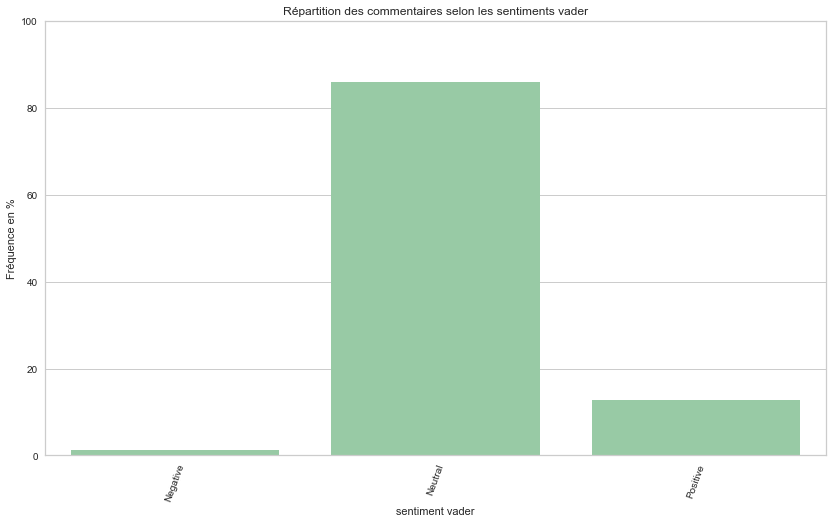

In [55]:
pk.graph_barplot(reviews['feeling_avg'],
                  "Répartition des commentaires selon les sentiments vader",
                  (0.564, 0.823, 0.631),
                   0, 100, "sentiment vader", "Fréquence en %",70, 1, (14,8))

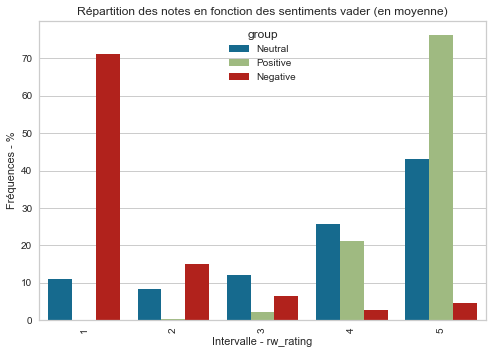

In [56]:
pk.graph_barplot_by_group(reviews, 'rw_rating', 'feeling_avg', '#6D8260', 'Répartition des notes en fonction des sentiments vader (en moyenne)')


In [ ]:
for i in reviews.loc[reviews["feeling_avg"]=='Negative']["rw_text"].head(10):
    print(i)

michelin one thing ill always carry with me when i think back on my trip to paris was not only the food because its amazing but the smell of the
while this was not the best meal i had in paris it was probably the best service i received the cobb salad was visually if not delectably special the
admittedly my review is  years late i was last in paris in spring  my mother had died the week before i stumbled on this place by accident the
terrible service we got inside and sat down and no waiter approached in  minutes the waiter acted like we were a burden to her just for setting the


In [ ]:
for idx, i in reviews.loc[reviews["rw_rating"]==5].head(10).iterrows():
    print(i["rw_text"], " ", str(i["compound"]))

my favorite meal in paris we started off with the foie gras carpaccio and escargot love the unique way that the foie gras was prepared and so thinly   0.8442
this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or dinner if i am close by the hostess is very friendly the   0.5413
this is for a review from  this place is perfect would recommend  prices are great food is astoundingand i never leave reviews   0.8872
michelin starred reservations weeks in advance is absolutely necessary to dine at an establishment like this my second time here very sophisticated vibe   0.5984
when i visited paris last week i had stopped by here by a recommendation of a friend and also recommended by bourdain this place was amazing and lives up   0.7845
based on some research we decided to book a reservation here for a meal on our first night in paris with our friends  families   kids  adults it   0.4767
if you know you know hands down my absolute favorite restaurant in p

Nous conservons les reviews inférieur ou égal à 1.

In [18]:
reviews_sav = reviews.copy()

In [19]:
reviews = reviews_sav.loc[reviews_sav["rw_rating"]<=1].copy()

In [20]:
import dill
dill.dump_session('notebook_env.db')

In [11]:
import dill
dill.load_session('notebook_env.db')

FileNotFoundError: [Errno 2] No such file or directory: 'notebook_env.db'

Regardons les sujets qui ressortent à l'aide d'un graphique word cloud

In [14]:
from wordcloud import WordCloud
from PIL import Image

In [61]:
gc.collect()

7737

In [63]:
reviews.head(2)

rw_id  rw_rating  \
111  wejeLM6zS_qWL6U4rU0okg          1   
9    BkdgkKU1uvUW0-LhfS2JVw          1   

                                               rw_text  \
111  service was super nice and friendly we are her...   
9    the food better be good because the iced coffe...   

                                              new_text  \
111  service  super nice  friendly     dinner one n...   
9     food better  good because  iced coffee  horri...   

                                     text_tagged_nn_vb  \
111  service super nice friendly dinner night reall...   
9    food better good iced coffee horrible service ...   

                                        words_subjects  \
111             service dinner night place food prices   
9    food coffee service deplorableparty minutes mi...   

                                     words_subjects_st  \
111               service dinner night place food pric   
9    food coffee service deplorableparty minutes mi...   

                                    words_subjects_lem  \
111             service dinner night place food prices   
9    food coffee service deplorableparty minutes mi...   

                                  text_tagged_nn_vb_st  \
111  service super nice friendly dinner night reall...   
9    food better good iced coffee horrible service ...   

                                  text_nn_vb_lem_feels  feeling_neg  \
111  service super nice friendly dinner night reall...        0.096   
9    food better good iced coffee horrible service ...        0.085   

     feeling_neu  feeling_pos  feeling_compound feeling_avg  
111        0.399        0.505            0.8826    Positive  
9          0.633        0.282            0.7964     Neutral

In [65]:
all_reviews = " ".join(reviews["words_subjects"])

In [67]:
reviews.shape

(23985, 15)

In [68]:
all_reviews = " ".join(reviews["words_subjects"])

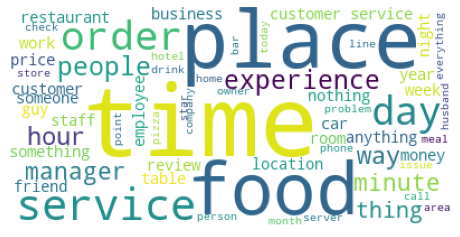

In [69]:
wordcloud = WordCloud(background_color = 'white', max_words = 60).generate(all_reviews)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Nous remarquons que les sujets principaux sont le repas, le service, le restaurant, la localisation et le menu.

In [22]:
def wordcloud_plot(data):
    all_reviews = data.str.cat(sep=' ')
    wordcloud = WordCloud(background_color = 'white', max_words = 60).generate(all_reviews)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [203]:
reviews.columns

Index(['rw_id', 'rw_rating', 'rw_text', 'new_text', 'text_tagged_nn_vb',
       'words_subjects', 'words_subjects_st', 'words_subjects_lem',
       'text_tagged_nn_vb_st', 'text_nn_vb_lem_feels', 'feeling_neg',
       'feeling_neu', 'feeling_pos', 'feeling_compound', 'feeling_avg'],
      dtype='object')

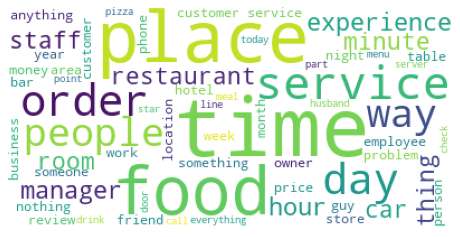

In [71]:
wordcloud_plot(reviews["words_subjects_st"])

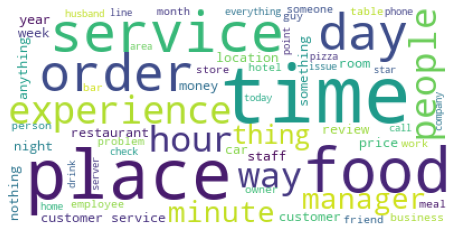

In [72]:
wordcloud_plot(reviews["words_subjects_lem"])

La colonne words_subjects semble donner de meilleurs résultats

## Features : deux méthodes BOW & TF-IDF

### BOW

le modèle CBOW prédit le mot actuel en fonction des mots du contexte dans une fenêtre spécifique:
- La couche d'entrée contient les mots de contexte
- la couche de sortie contient le mot courant
- la couche cachée contient le nombre de dimensions dans lesquelles nous voulons représenter le mot actuel présent à la couche de sortie.

In [8]:
reviews.head(2)

rw_id  rw_rating  \
111  wejeLM6zS_qWL6U4rU0okg          1   
9    BkdgkKU1uvUW0-LhfS2JVw          1   

                                               rw_text  \
111  service was super nice and friendly we are her...   
9    the food better be good because the iced coffe...   

                                              new_text  \
111  service  super nice  friendly     dinner one n...   
9     food better  good because  iced coffee  horri...   

                                     text_tagged_nn_vb  \
111  service super nice friendly dinner night reall...   
9    food better good iced coffee horrible service ...   

                                        words_subjects  \
111             service dinner night place food prices   
9    food coffee service deplorableparty minutes mi...   

                                     words_subjects_st  \
111               service dinner night place food pric   
9    food coffee service deplorableparty minutes mi...   

                                    words_subjects_lem  \
111             service dinner night place food prices   
9    food coffee service deplorableparty minutes mi...   

                                  text_tagged_nn_vb_st  \
111  service super nice friendly dinner night reall...   
9    food better good iced coffee horrible service ...   

                                  text_nn_vb_lem_feels  feeling_neg  \
111  service super nice friendly dinner night reall...        0.096   
9    food better good iced coffee horrible service ...        0.085   

     feeling_neu  feeling_pos  feeling_compound feeling_avg  
111        0.399        0.505            0.8826    Positive  
9          0.633        0.282            0.7964     Neutral

In [13]:
reviews.shape

(5000, 15)

In [23]:
reviews_compl = reviews.copy()

In [13]:
reviews_compl.shape

(23985, 15)

In [14]:
reviews = reviews_compl.sample(6000)

In [15]:
reviews = reviews.reset_index()

In [16]:
from  sklearn.feature_extraction.text  import CountVectorizer 
# créer un vecteur d'objet 
vectorizer = CountVectorizer()
corpus = reviews["words_subjects_lem"]


In [14]:
gc.collect()

0

In [18]:
# apprendre le vocabulaire et stocker la matrice creuse CountVectorizer dans X 
cbow = vectorizer.fit_transform(corpus).todense()
new_cols = vectorizer.get_feature_names()

In [19]:
reviews.head(2)

index                   rw_id  rw_rating  \
0   34859  EaSJOc9zoW8FvlrZ3JAq0Q          1   
1  140331  PrG8ohauxUI4N8_clQAo0A          1   

                                             rw_text  \
0  horrible experience we made reservations in ad...   
1  worst experience in a restaurant ever food was...   

                                            new_text  \
0  horrible experience  made reservations  advanc...   
1  worst experience   restaurant ever food  broug...   

                                   text_tagged_nn_vb  \
0  horrible experience made reservations advance ...   
1  worst experience restaurant ever food brought ...   

                                      words_subjects  \
0  experience reservations advance table party ma...   
1  experience restaurant food minutes owner fishy...   

                                   words_subjects_st  \
0  experience reservations advance table party ma...   
1  experience restaurant food minutes owner fishy...   

                                  words_subjects_lem  \
0  experience reservations advance table party ma...   
1  experience restaurant food minutes owner fishy...   

                                text_tagged_nn_vb_st  \
0  horrible experience made reservations advance ...   
1  worst experience restaurant ever food brought ...   

                                text_nn_vb_lem_feels  feeling_neg  \
0  horrible experience made reservations advance ...        0.131   
1  worst experience restaurant ever food brought ...        0.169   

   feeling_neu  feeling_pos  feeling_compound feeling_avg  
0        0.766        0.104           -0.5318     Neutral  
1        0.695        0.136           -0.4585     Neutral

In [29]:
# join the tfidf values to the existing dataframe
reviews = reviews.join(pd.DataFrame(cbow, columns=new_cols),rsuffix="_left")

In [21]:
reviews.head(2)

index                   rw_id  rw_rating  \
0  209851  AactXP4rMr0jhK2Vyd1g2g          1   
1  196296  gBEBLNlY3AjBExSJHwWgUg          1   

                                             rw_text  \
0  my boyfriend just went in because we got a fre...   
1  rude and very unprofessional  i have never had...   

                                            new_text  \
0   boyfriend  went  because  got  free mvp coupo...   
1  rude  very unprofessional    never  such  horr...   

                                   text_tagged_nn_vb  \
0  boyfriend went got free mvp coupon mail not on...   
1  rude very unprofessional never such horrible e...   

                      words_subjects               words_subjects_st  \
0  mvp coupon mail cowlick hair rate  mvp coupon mail cowlick hair r   
1                   experience money                experience money   

                  words_subjects_lem  \
0  mvp coupon mail cowlick hair rate   
1                   experience money   

                                text_tagged_nn_vb_st  ... zoodles  zoom  zoos  \
0  boyfriend went got free mvp coupon mail not on...  ...       0     0     0   
1  rude very unprofessional never such horrible e...  ...       0     0     0   

   zorbas  zucchini zupas  zuppa  zuppas  zydeco  zydecos  
0       0         0     0      0       0       0        0  
1       0         0     0      0       0       0        0  

[2 rows x 23070 columns]

### TF-IDF

Matrice avec les noms pour trouver les themes abordés dans le corpus. Puis après, refaire une matrice avec theme + word_ok pour avoir les sentiments sur les themes.

In [15]:
gc.collect()

0

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(reviews["words_subjects_lem"]).todense()
new_cols = vectorizer.get_feature_names()


In [32]:
tfidf_df = pd.DataFrame(tfIdf, columns=new_cols)

In [33]:
tfidf_df.head(2)

aaa  aaand  aand  aaron  aarrrgghhh  aback  abacus  abalone  abandon  \
0  0.0    0.0   0.0    0.0         0.0    0.0     0.0      0.0      0.0   
1  0.0    0.0   0.0    0.0         0.0    0.0     0.0      0.0      0.0   

   abbreviate  ...  zoneblind  zoo  zoom  zorbas  zucchini  zuppa  zwei  \
0         0.0  ...        0.0  0.0   0.0     0.0       0.0    0.0   0.0   
1         0.0  ...        0.0  0.0   0.0     0.0       0.0    0.0   0.0   

   zydeco  zydecos  zzzzzzzx  
0     0.0      0.0       0.0  
1     0.0      0.0       0.0  

[2 rows x 18401 columns]

In [26]:
reviews.head(2)

index                   rw_id  rw_rating  \
0  209851  AactXP4rMr0jhK2Vyd1g2g          1   
1  196296  gBEBLNlY3AjBExSJHwWgUg          1   

                                             rw_text  \
0  my boyfriend just went in because we got a fre...   
1  rude and very unprofessional  i have never had...   

                                            new_text  \
0   boyfriend  went  because  got  free mvp coupo...   
1  rude  very unprofessional    never  such  horr...   

                                   text_tagged_nn_vb  \
0  boyfriend went got free mvp coupon mail not on...   
1  rude very unprofessional never such horrible e...   

                      words_subjects               words_subjects_st  \
0  mvp coupon mail cowlick hair rate  mvp coupon mail cowlick hair r   
1                   experience money                experience money   

                  words_subjects_lem  \
0  mvp coupon mail cowlick hair rate   
1                   experience money   

                                text_tagged_nn_vb_st  ... zoodles  zoom  zoos  \
0  boyfriend went got free mvp coupon mail not on...  ...       0     0     0   
1  rude very unprofessional never such horrible e...  ...       0     0     0   

   zorbas  zucchini zupas  zuppa  zuppas  zydeco  zydecos  
0       0         0     0      0       0       0        0  
1       0         0     0      0       0       0        0  

[2 rows x 23070 columns]

In [34]:
# join the tfidf values to the existing dataframe
reviews = reviews.join(tfidf_df, rsuffix='_tfidf')

In [28]:
reviews.head(2)

index                   rw_id  rw_rating  \
0  209851  AactXP4rMr0jhK2Vyd1g2g          1   
1  196296  gBEBLNlY3AjBExSJHwWgUg          1   

                                             rw_text  \
0  my boyfriend just went in because we got a fre...   
1  rude and very unprofessional  i have never had...   

                                            new_text  \
0   boyfriend  went  because  got  free mvp coupo...   
1  rude  very unprofessional    never  such  horr...   

                                   text_tagged_nn_vb  \
0  boyfriend went got free mvp coupon mail not on...   
1  rude very unprofessional never such horrible e...   

                      words_subjects               words_subjects_st  \
0  mvp coupon mail cowlick hair rate  mvp coupon mail cowlick hair r   
1                   experience money                experience money   

                  words_subjects_lem  \
0  mvp coupon mail cowlick hair rate   
1                   experience money   

                                text_tagged_nn_vb_st  ... zoodles_tfidf  \
0  boyfriend went got free mvp coupon mail not on...  ...           0.0   
1  rude very unprofessional never such horrible e...  ...           0.0   

   zoom_tfidf  zoos_tfidf  zorbas_tfidf  zucchini_tfidf zupas_tfidf  \
0         0.0         0.0           0.0             0.0         0.0   
1         0.0         0.0           0.0             0.0         0.0   

   zuppa_tfidf  zuppas_tfidf  zydeco_tfidf  zydecos_tfidf  
0          0.0           0.0           0.0            0.0  
1          0.0           0.0           0.0            0.0  

[2 rows x 46124 columns]

Maintenant que nous avons ajouté nos features, nous pouvons réaliser une PCA afin de voir quelles sont les variables qui expliquent au mieux nos données.

# Analyse multidimensionnelle : ACP / T-SNE / UMAP

ajouts infos des methodes

In [ ]:
import dill
dill.dump_session('notebook_env_2.db')

In [53]:
import dill
dill.load_session('notebook_env_2.db')

In [21]:
reviews.shape

(10000, 36818)

In [54]:
reviews = reviews.sample(7000)

In [55]:
del reviews["index"]

In [56]:
df_acp = reviews.copy()


In [29]:
df_acp.head(2)

rw_id  rw_rating  \
8530  o3F07qvlpJcKz56RpFmxpw          1   
3427  VrBqRF7bS7mH_sOWIu9arg          1   

                                                rw_text  \
8530  horrible please please please do not eat here ...   
3427  we went there recently because the reviews are...   

                                               new_text  \
8530  horrible please please please  not eat    neve...   
3427   went  recently because  reviews  good  went  ...   

                                      text_tagged_nn_vb  \
8530  horrible please please please not eat never li...   
3427  went recently reviews good went friday night s...   

                                         words_subjects  \
8530  please please life city service service food c...   
3427  reviews night snob sushi giants sushi mushy fr...   

                                      words_subjects_st  \
8530  please please life city service service food c...   
3427  reviews night snob sushi giants sushi mushy fr...   

                                     words_subjects_lem  \
8530  please please life city service service food c...   
3427  reviews night snob sushi giants sushi mushy fr...   

                                   text_tagged_nn_vb_st  \
8530  horrible please please please not eat never li...   
3427  went recently reviews good went friday night s...   

                                   text_nn_vb_lem_feels  ...  zoneblind_tfidf  \
8530  horrible please please please not eat never li...  ...              0.0   
3427  went recently reviews good went friday night s...  ...              0.0   

      zoo_tfidf  zoom_tfidf  zorbas_tfidf zucchini_tfidf  zuppa_tfidf  \
8530        0.0         0.0           0.0            0.0          0.0   
3427        0.0         0.0           0.0            0.0          0.0   

      zwei_tfidf  zydeco_tfidf  zydecos_tfidf  zzzzzzzx_tfidf  
8530         0.0           0.0            0.0             0.0  
3427         0.0           0.0            0.0             0.0  

[2 rows x 36817 columns]

In [57]:
gc.collect()

26264

In [58]:
df_acp2 = df_acp.drop(["rw_id", "rw_rating", "rw_text", "new_text", "text_tagged_nn_vb", "words_subjects", "words_subjects_st", "words_subjects_lem", "text_tagged_nn_vb_st"], axis=1)

In [59]:
del df_acp2["text_nn_vb_lem_feels"]

In [60]:
del df_acp2["feeling_avg"]

In [61]:
df_acp2.head(2) #####ici

feeling_neg  feeling_neu  feeling_pos  feeling_compound  aaa  aaand  \
8747        0.221        0.779        0.000           -0.8043    0      0   
3384        0.105        0.683        0.212            0.8257    0      0   

      aand  aaron  aarrrgghhh  aback  ...  zoneblind_tfidf  zoo_tfidf  \
8747     0      0           0      0  ...              0.0        0.0   
3384     0      0           0      0  ...              0.0        0.0   

      zoom_tfidf  zorbas_tfidf  zucchini_tfidf  zuppa_tfidf  zwei_tfidf  \
8747         0.0           0.0             0.0          0.0         0.0   
3384         0.0           0.0             0.0          0.0         0.0   

      zydeco_tfidf  zydecos_tfidf  zzzzzzzx_tfidf  
8747           0.0            0.0             0.0  
3384           0.0            0.0             0.0  

[2 rows x 36806 columns]

### ACP

In [62]:
gc.collect()

0

In [16]:
Z = pk_multi.amulti_acp_standard(df_acp2)
pk_multi.amulti_acp_choice_dim(df_acp2, Z)

MemoryError: Unable to allocate 2.74 GiB for an array with shape (10000, 36806) and data type float64

Il faudrait 12 dimensions pour obtenir 80% de la variance expliquée.

In [14]:
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.decomposition import SparsePCA


In [279]:
transformer = SparsePCA(n_components=12, random_state=0)
transformer.fit(df_acp2)

X_transformed = transformer.transform(df_acp2)
X_transformed.shape

# most values in the components_ are zero (sparsity)
np.mean(transformer.components_ == 0)

0.997687969924812

In [280]:
X_transformed.shape

(5000, 12)

[Text(0.5, 1.0, 'Data SparsePCA projection')]

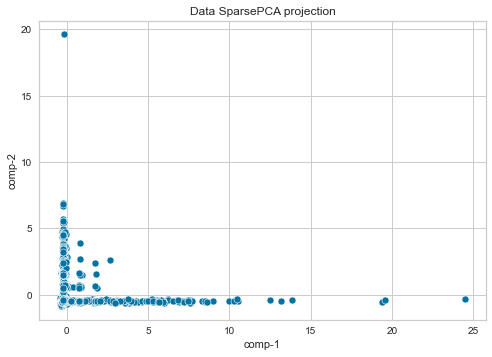

In [281]:
df_sparseacp = pd.DataFrame()
df_sparseacp["comp-1"] = X_transformed[:,0]
df_sparseacp["comp-2"] = X_transformed[:,1]

sns.scatterplot(x="comp-1", y="comp-2", #hue=df_sparseacp.y.tolist(),
                #palette=sns.color_palette("hls", 3),
                data=df_sparseacp).set(title="Data SparsePCA projection") 

In [282]:
Z = pk_multi.amulti_acp_standard(X_transformed)

12
[1.92704977 1.38233467 1.13035934 1.01956986 0.97340444 0.94822984
 0.89184401 0.84204541 0.79654033 0.76951494 0.6953035  0.62620435]
[0.16055536 0.11517152 0.09417777 0.08494716 0.08110081 0.07900335
 0.07430547 0.07015642 0.06636509 0.06411342 0.05793037 0.05217326]
   Dimension  Valeurs propres  % variance expliquée  % cum. var. expliquée
0       Dim1         1.926664                  16.0                   16.0
1       Dim2         1.382058                  12.0                   28.0
2       Dim3         1.130133                   9.0                   37.0
3       Dim4         1.019366                   8.0                   45.0
4       Dim5         0.973210                   8.0                   54.0
5       Dim6         0.948040                   8.0                   61.0
6       Dim7         0.891666                   7.0                   69.0
7       Dim8         0.841877                   7.0                   76.0
8       Dim9         0.796381                   7.0 

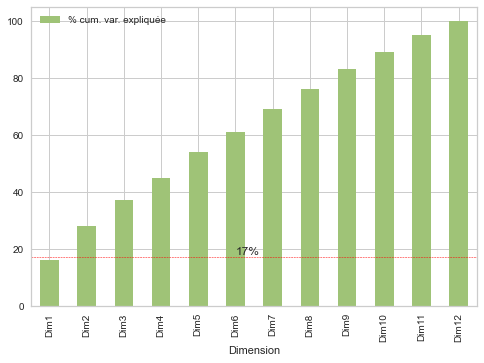

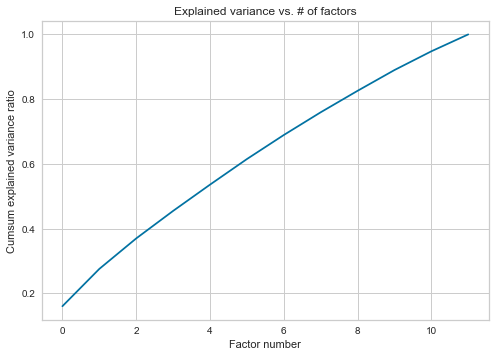

In [290]:
pk_multi.amulti_acp_choice_dim(X_transformed, Z)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


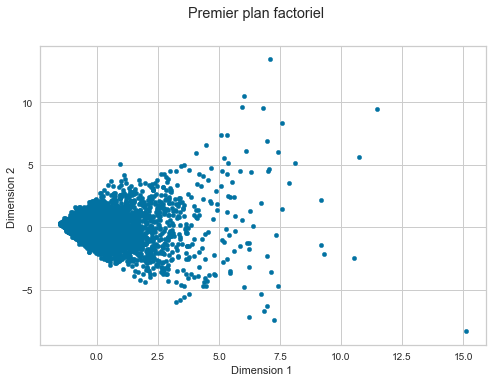

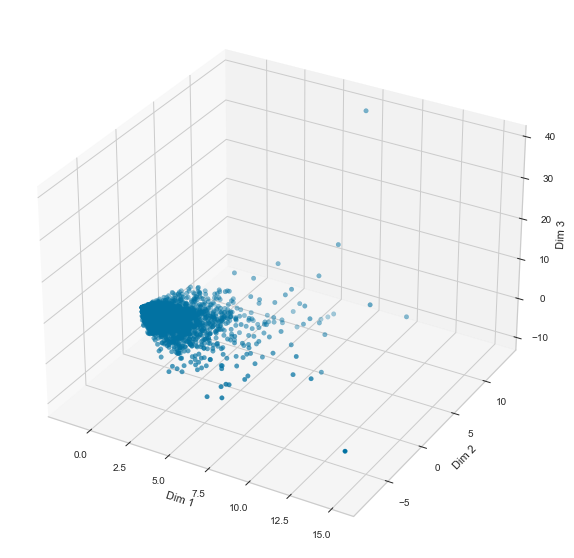

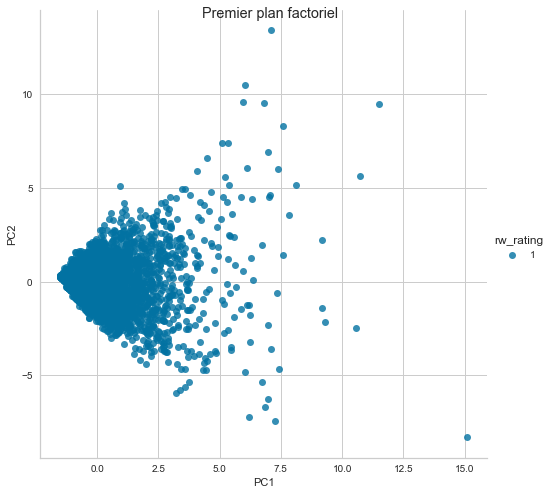

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

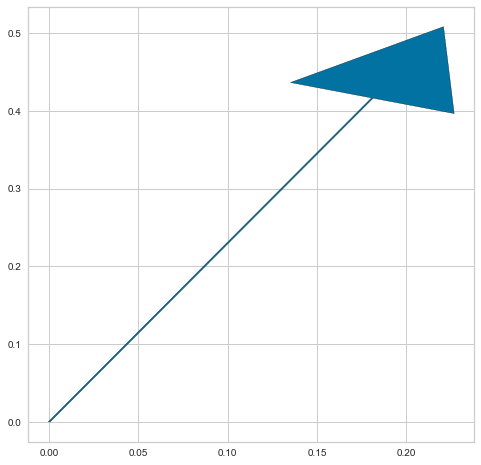

In [289]:
#pk.amultiacp_visualizer(df_acp2, Z, 3, df_acp,df_acp["customer_unique_id"], df_acp["order_id_size"], "order_id_size")
pk_multi.amultiacp_visualizer(X_transformed, Z, 3, df_acp, df_acp["words_subjects"], reviews["rw_rating"], "rw_rating")

### T-SNE

[t-SNE] Computing 20 nearest neighbors...
[t-SNE] Indexed 21 samples in 0.001s...
[t-SNE] Computed neighbors for 21 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 21 / 21
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.808231
[t-SNE] KL divergence after 300 iterations: 0.715921


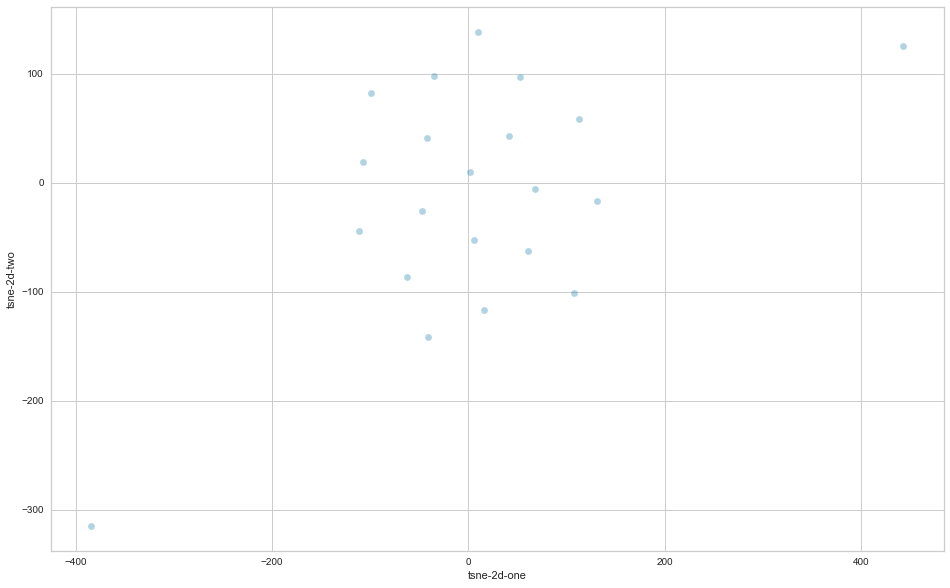

In [308]:
pk_multi.tsne_graph(df_acp2, group=0, by="")

### UMAP

In [309]:
pk_multi.umap_graphs(df_acp2)

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning:

The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11103. The TBB threading layer is disabled.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



# Modèle : LDA / K-means / Bert

In [99]:
gc.collect()

0

In [292]:
reviews.head(2)

rw_id  rw_rating  \
0  3m2Z9mMC5rLcynKFCZGcsQ          1   
1  6recrX_SsLVf-WjIgtCvXA          1   

                                             rw_text  \
0  shocking lifetime titanium member who cares  e...   
1  the companys incompetence  is incredible becky...   

                                            new_text  \
0  shocking lifetime titanium member  cares  ever...   
1   companys incompetence   incredible becky  one...   

                                   text_tagged_nn_vb  \
0  shocking lifetime titanium member cares everyo...   
1  companys incompetence incredible becky writes ...   

                                      words_subjects  \
0  [titanium, member, everyone, dirt, property, r...   
1  [companys, incompetence, posts, thing, informa...   

                                   words_subjects_st  \
0  titanium member everyone dirt property restaur...   
1  companys incompetence posts thing information ...   

                                  words_subjects_lem  \
0  titanium member everyone dirt property restaur...   
1  companys incompetence posts thing information ...   

                                text_tagged_nn_vb_st  \
0  shocking lifetime titanium member cares everyo...   
1  companys incompetence incredible becky writes ...   

                                text_nn_vb_lem_feels  ...  zits_tfidf  \
0  shocking lifetime titanium member cares everyo...  ...         0.0   
1  companys incompetence incredible becky writes ...  ...         0.0   

   zocdoc_tfidf  zollinger_tfidf  zollingers_tfidf zombie_tfidf  zone_tfidf  \
0           0.0              0.0               0.0          0.0         0.0   
1           0.0              0.0               0.0          0.0         0.0   

   zoo_tfidf  zoodles_tfidf  zoom_tfidf  zucchini_tfidf  
0        0.0            0.0         0.0             0.0  
1        0.0            0.0         0.0             0.0  

[2 rows x 26611 columns]

In [63]:
reviews["words_token_lem"] = reviews["words_subjects_lem"].progress_apply(lambda x: word_tokenize(x))

  0%|          | 0/7000 [00:00<?, ?it/s]

In [100]:
reviews["words_token_lem"]

8747    [dunkin, donuts, people, line, drivethru, street, minutes, people, restaurant, breakfast, place,...
3384    [shore, mall, today, florida, product, goodness, find, offer, orders, cinnamon, pretzel, annes, ...
266     [food, service, think, anything, hand, mind, husband, reservations, turnaround, people, minutes,...
5875    [golfnowcom, course, office, counter, attitude, anything, play, golfwe, play, times, week, cours...
9454                                         [sorry, place, gel, nails, bumpy, tell, gel, time, beds, luck]
                                                       ...                                                 
6444    [place, eat, bit, downhill, place, garbage, cans, garbage, tables, garbage, cans, nothing, sauce...
9036    [place, pastrami, sandwich, bread, pastrami, bread, rye, bread, rolls, strings, pastrami, fatty,...
4804    [group, girls, tables, everyone, checks, confusion, tolerable, tables, minutes, subpar, ya, hate...
9846    [night, dessert, din

In [37]:
reviews.head(2)

rw_id  rw_rating  \
8530  o3F07qvlpJcKz56RpFmxpw          1   
3427  VrBqRF7bS7mH_sOWIu9arg          1   

                                                rw_text  \
8530  horrible please please please do not eat here ...   
3427  we went there recently because the reviews are...   

                                               new_text  \
8530  horrible please please please  not eat    neve...   
3427   went  recently because  reviews  good  went  ...   

                                      text_tagged_nn_vb  \
8530  horrible please please please not eat never li...   
3427  went recently reviews good went friday night s...   

                                         words_subjects  \
8530  please please life city service service food c...   
3427  reviews night snob sushi giants sushi mushy fr...   

                                      words_subjects_st  \
8530  please please life city service service food c...   
3427  reviews night snob sushi giants sushi mushy fr...   

                                     words_subjects_lem  \
8530  please please life city service service food c...   
3427  reviews night snob sushi giants sushi mushy fr...   

                                   text_tagged_nn_vb_st  \
8530  horrible please please please not eat never li...   
3427  went recently reviews good went friday night s...   

                                   text_nn_vb_lem_feels  ...  zoo_tfidf  \
8530  horrible please please please not eat never li...  ...        0.0   
3427  went recently reviews good went friday night s...  ...        0.0   

      zoom_tfidf  zorbas_tfidf  zucchini_tfidf zuppa_tfidf  zwei_tfidf  \
8530         0.0           0.0             0.0         0.0         0.0   
3427         0.0           0.0             0.0         0.0         0.0   

      zydeco_tfidf  zydecos_tfidf  zzzzzzzx_tfidf  \
8530           0.0            0.0             0.0   
3427           0.0            0.0             0.0   

                                        words_token_lem  
8530  [please, please, life, city, service, service,...  
3427  [reviews, night, snob, sushi, giants, sushi, m...  

[2 rows x 36818 columns]

In [64]:
# Create Dictionary
id2word = corpora.Dictionary(reviews["words_token_lem"])

# Create Corpus
texts = reviews["words_token_lem"]

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 1), (8, 1), (9, 1)]]


In [65]:
gc.collect()

0

In [105]:
id2word[0]

'chance'

In [317]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('boo', 2),
  ('hours', 1),
  ('museum', 1),
  ('setup', 1),
  ('staff', 1),
  ('wait', 1)]]

In [318]:
corpus

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
 [(6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1)],
 [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1)],
 [(7, 1), (15, 1), (17, 1), (18, 1), (19, 1), (20, 1)],
 [],
 [(9, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)],
 [(28, 1), (29, 1), (30, 1)],
 [(31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)],
 [(37, 1), (38, 1), (39, 1), (40, 1)],
 [(9, 1), (41, 1), (42, 1), (43, 1)],
 [(4, 1), (44, 1), (45, 1), (46, 1), (47, 1)],
 [(48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1)],
 [(11, 1), (49, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1)],
 [(15, 1), (40, 1), (49, 1), (61, 1), (62, 1)],
 [(49, 2), (63, 1)],
 [(40, 1), (49, 1), (64, 1), (65, 1)],
 [(9, 1), (40, 1), (49, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1)],
 [(49, 1), (71, 1), (72, 1), (73, 1)],
 [(74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1)],
 [(40, 1), (49, 1), (80, 1)],
 [(81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1

In [40]:
from gensim.models.ldamodel import LdaModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=1, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [41]:
gc.collect()

0

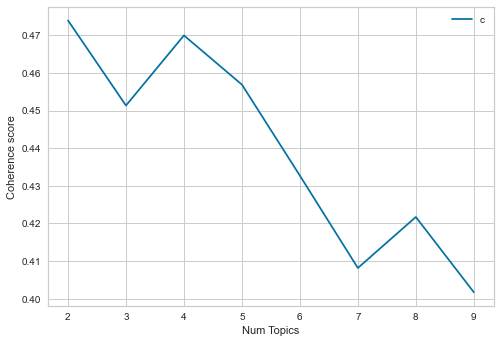

Num Topics = 2  has Coherence Value of 0.474
Num Topics = 3  has Coherence Value of 0.4513
Num Topics = 4  has Coherence Value of 0.47
Num Topics = 5  has Coherence Value of 0.4569
Num Topics = 6  has Coherence Value of 0.4327
Num Topics = 7  has Coherence Value of 0.4082
Num Topics = 8  has Coherence Value of 0.4217
Num Topics = 9  has Coherence Value of 0.4017


In [70]:
# Calculer les scores de cohérence entre 2 et 10 topics (Cela peut prendre un certain temps)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=10, step=1)

# Afficher un graphique
limit=10
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Affchier les coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))  #le 4 correspond au nombre de décimales du c

In [71]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [72]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.039*"service" + 0.039*"time" + 0.024*"place" + 0.021*"minutes" + 0.019*"customer" + 0.017*"people" + 0.017*"manager" + 0.014*"way" + 0.014*"experience" + 0.012*"money"'), (1, '0.024*"water" + 0.020*"hair" + 0.017*"lot" + 0.015*"coffee" + 0.013*"fries" + 0.012*"employees" + 0.011*"couple" + 0.011*"beer" + 0.008*"woman" + 0.008*"wings"'), (2, '0.027*"car" + 0.025*"room" + 0.014*"hotel" + 0.012*"day" + 0.012*"company" + 0.010*"days" + 0.009*"phone" + 0.008*"call" + 0.008*"charge" + 0.008*"week"'), (3, '0.084*"food" + 0.030*"order" + 0.018*"restaurant" + 0.016*"place" + 0.009*"waitress" + 0.009*"meal" + 0.009*"drinks" + 0.009*"chicken" + 0.008*"eat" + 0.008*"dinner"')]


In [73]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews["words_token_lem"], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.841599560576884

Coherence Score:  0.48719134819503723


In [74]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.039*"service" + 0.039*"time" + 0.024*"place" + 0.021*"minutes" + '
  '0.019*"customer" + 0.017*"people" + 0.017*"manager" + 0.014*"way" + '
  '0.014*"experience" + 0.012*"money"'),
 (1,
  '0.024*"water" + 0.020*"hair" + 0.017*"lot" + 0.015*"coffee" + 0.013*"fries" '
  '+ 0.012*"employees" + 0.011*"couple" + 0.011*"beer" + 0.008*"woman" + '
  '0.008*"wings"'),
 (2,
  '0.027*"car" + 0.025*"room" + 0.014*"hotel" + 0.012*"day" + 0.012*"company" '
  '+ 0.010*"days" + 0.009*"phone" + 0.008*"call" + 0.008*"charge" + '
  '0.008*"week"'),
 (3,
  '0.084*"food" + 0.030*"order" + 0.018*"restaurant" + 0.016*"place" + '
  '0.009*"waitress" + 0.009*"meal" + 0.009*"drinks" + 0.009*"chicken" + '
  '0.008*"eat" + 0.008*"dinner"')]


In [75]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.5350   
1            1             2.0              0.3772   
2            2             0.0              0.5887   
3            3             0.0              0.5508   
4            4             0.0              0.3928   
5            5             0.0              0.4269   
6            6             0.0              0.5334   
7            7             0.0              0.6889   
8            8             2.0              0.5488   
9            9             0.0              0.7739   

                                                                           Keywords  \
0  service, time, place, minutes, customer, people, manager, way, experience, money   
1                   car, room, hotel, day, company, days, phone, call, charge, week   
2  service, time, place, minutes, customer, people, manager, way, experience, money   
3  service, time, place, minutes, customer, people, manager, way, experience, money   
4  service, time, place, minutes, customer, people, manager, way, experience, money   
5  service, time, place, minutes, customer, people, manager, way, experience, money   
6  service, time, place, minutes, customer, people, manager, way, experience, money   
7  service, time, place, minutes, customer, people, manager, way, experience, money   
8                   car, room, hotel, day, company, days, phone, call, charge, week   
9  service, time, place, minutes, customer, people, manager, way, experience, money   

                                                                                                  Text  
0                                               [food, greatthe, service, price, butttt, tip, options]  
1  [eat, excuse, togo, order, blonde, bartender, planet, bar, check, food, kitchen, bag, hand, home...  
2  [photo, studio, christmas, card, photos, purchase, day, photography, holidays, timing, christmas...  
3                                                  [staff, rude, time, thing, store, location, coffee]  
4                                       [gyro, hopes, chicken, thing, mess, way, hummus, flavors, eat]  
5                                                                                                  NaN  
6                              [appointments, receptionists, area, clinic, staff, nice, place, clinic]  
7                                                                                                  NaN  
8                                                                                                  NaN  
9                                     [front, desk, rudest, people, check, lunch, girl, places, order]

In [76]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet 

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9255   
1        1.0              0.9675   
2        2.0              0.8885   
3        3.0              0.8280   

                                                                           Keywords  \
0  service, time, place, minutes, customer, people, manager, way, experience, money   
1            water, hair, lot, coffee, fries, employees, couple, beer, woman, wings   
2                   car, room, hotel, day, company, days, phone, call, charge, week   
3      food, order, restaurant, place, waitress, meal, drinks, chicken, eat, dinner   

                                                                                   Representative Text  
0                                                  [service, food, breakfast, hash, brown, food, food]  
1  [stars, experience, bartender, drinks, plastic, cups, dollar, glass, wine, cup, dinner, menu, an...  
2  [car, tell, auction, chances, car, condition, car, auction, month, car, auction, car, owners, ca...  
3  [mid, family, time, animals, shots, news, april, hrsit, amclosing, hold, mins, records, sever, c...

TypeError: object of type 'float' has no len()

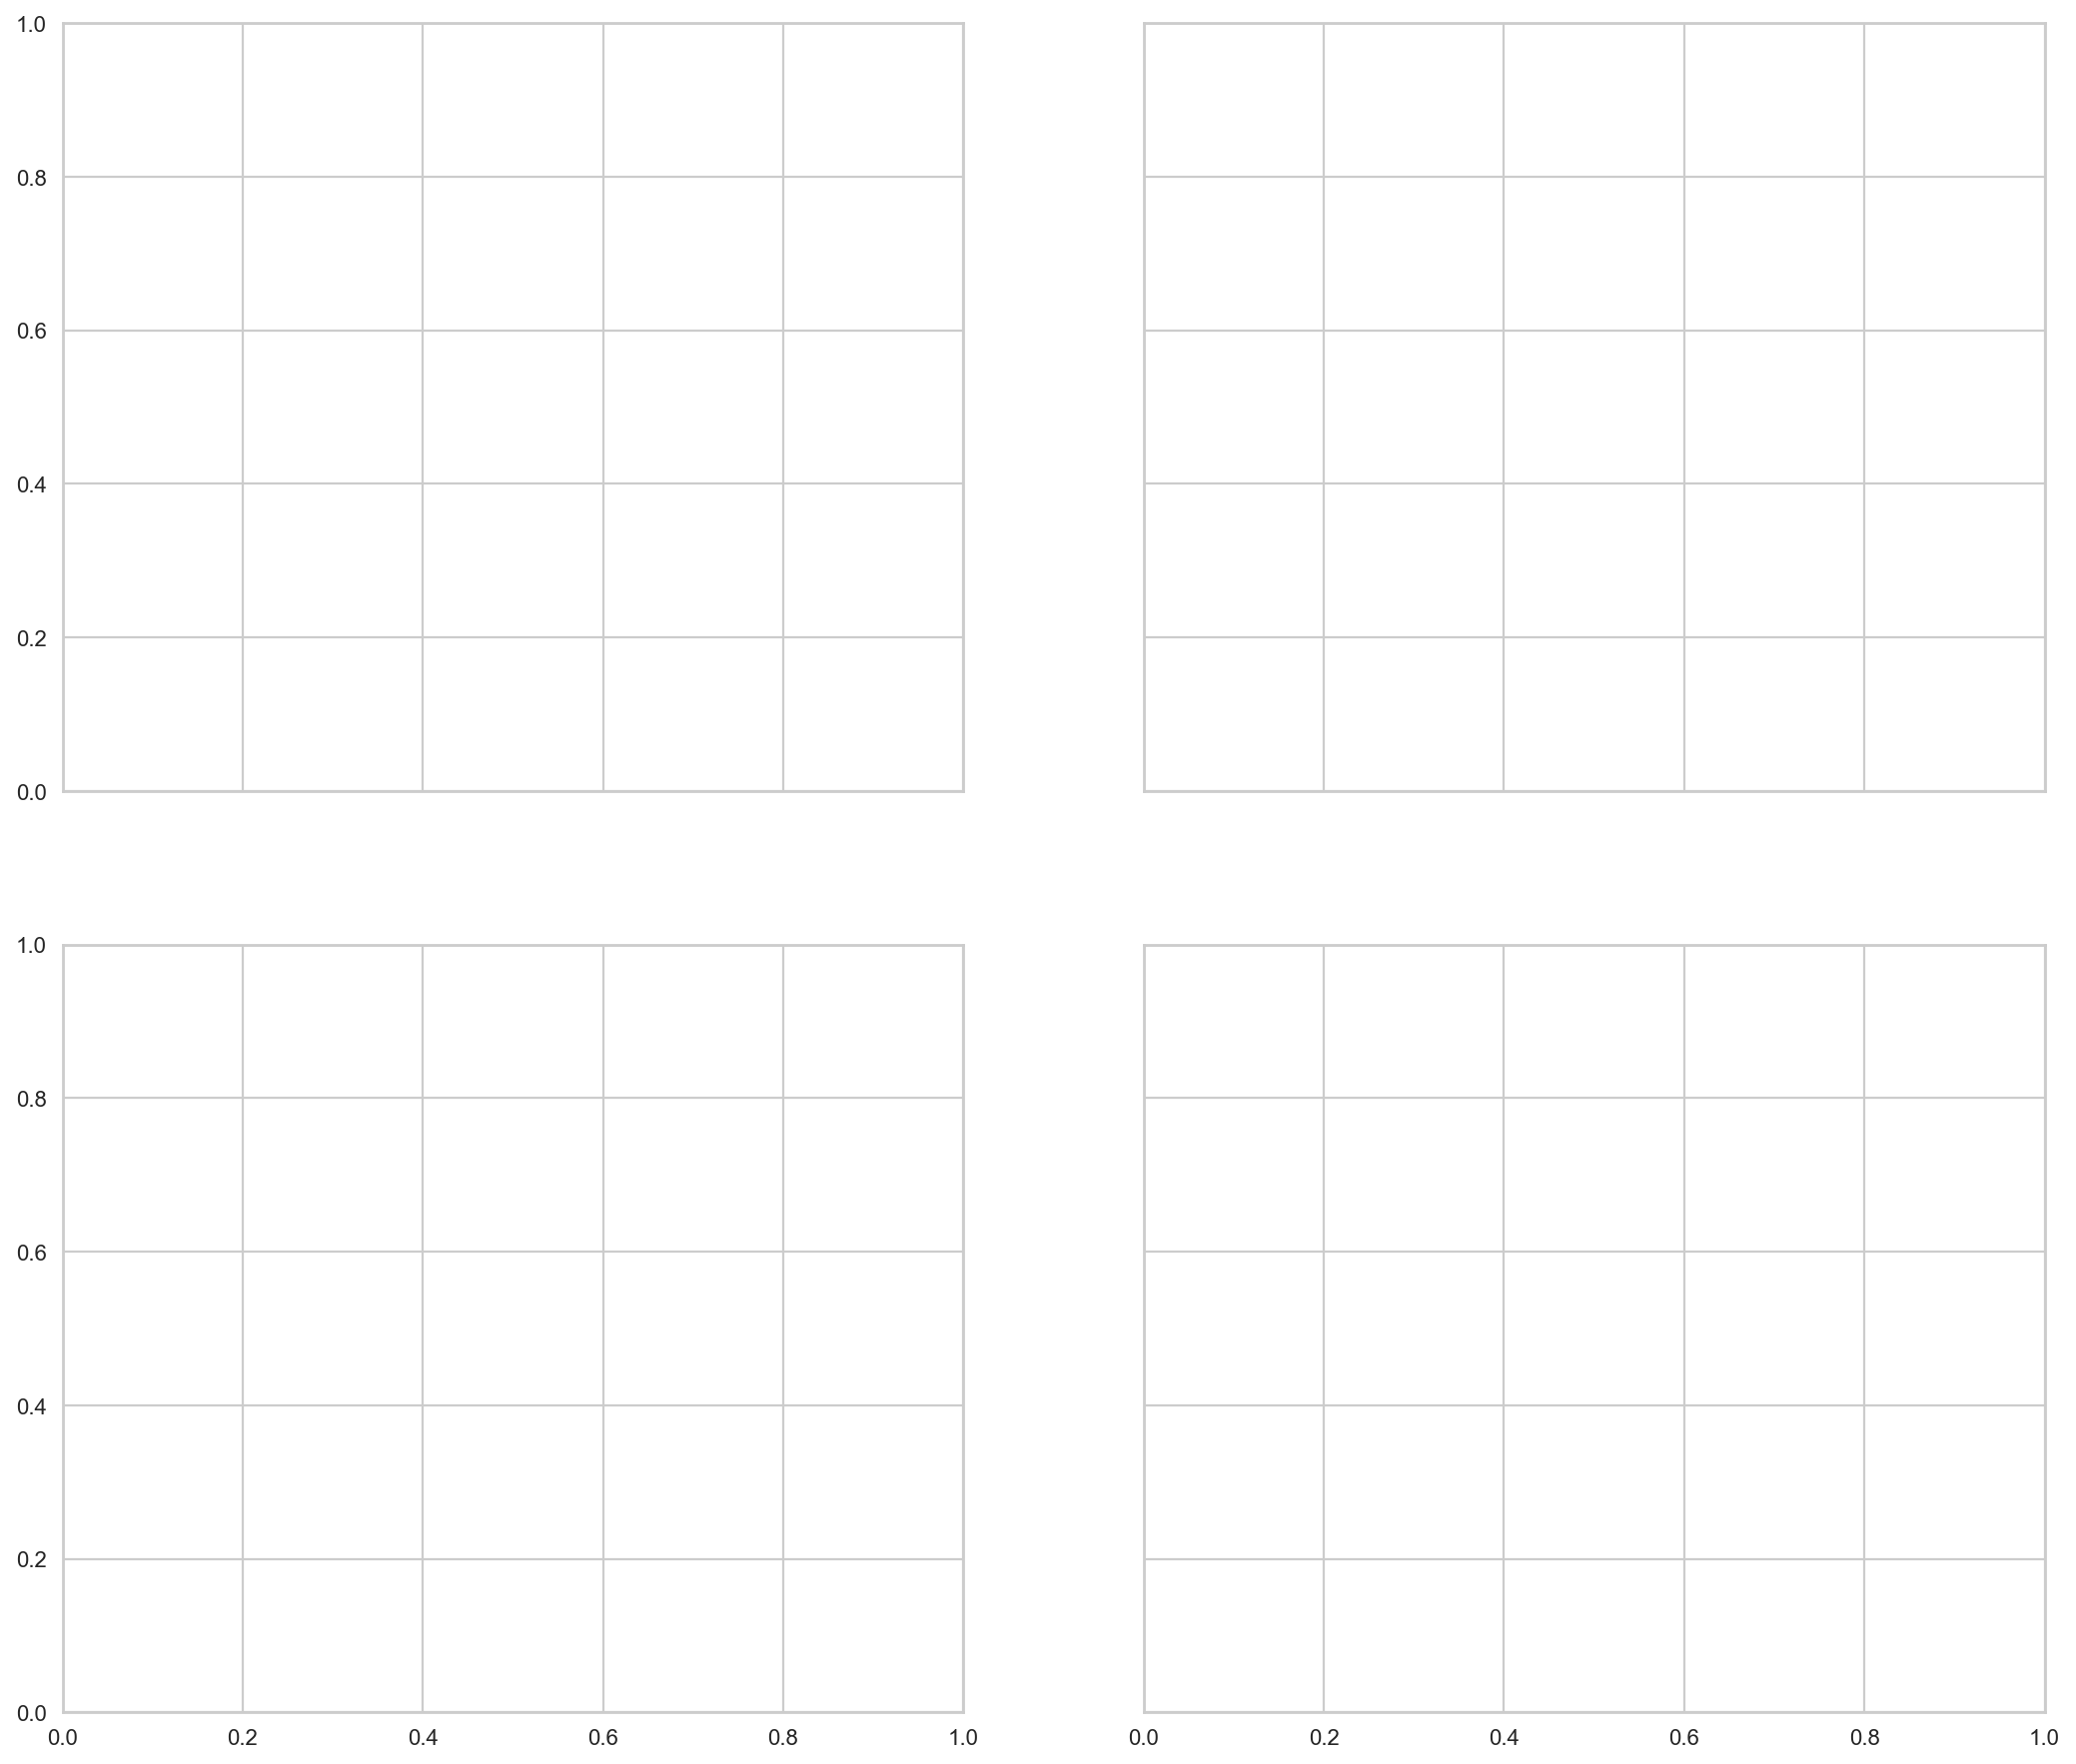

In [77]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 2, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 20), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,20,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [96]:
topics

[(0,
  [('service', 0.03919931),
   ('time', 0.038641237),
   ('place', 0.023677094),
   ('minutes', 0.020814056),
   ('customer', 0.018831437),
   ('people', 0.016831247),
   ('manager', 0.016583467),
   ('way', 0.014415687),
   ('experience', 0.01376085),
   ('money', 0.011541407)]),
 (1,
  [('water', 0.02386361),
   ('hair', 0.019686267),
   ('lot', 0.016631758),
   ('coffee', 0.014919556),
   ('fries', 0.012565545),
   ('employees', 0.012148948),
   ('couple', 0.011279159),
   ('beer', 0.010967458),
   ('woman', 0.008145721),
   ('wings', 0.007943757)]),
 (2,
  [('car', 0.027291289),
   ('room', 0.024872992),
   ('hotel', 0.014106045),
   ('day', 0.012039833),
   ('company', 0.011674311),
   ('days', 0.010264765),
   ('phone', 0.009106253),
   ('call', 0.008194677),
   ('charge', 0.007624087),
   ('week', 0.0075417473)]),
 (3,
  [('food', 0.08368342),
   ('order', 0.030424828),
   ('restaurant', 0.01751572),
   ('place', 0.015725773),
   ('waitress', 0.00930812),
   ('meal', 0.0087

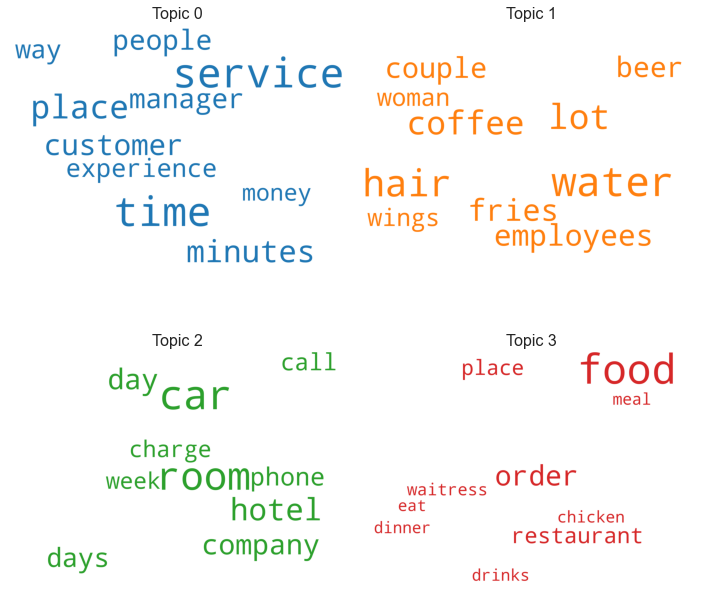

In [78]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_9456\2913163039.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\aurel\AppData\Local\Temp\ipykernel_9456\2913163039.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\aurel\AppData\Local\Temp\ipykernel_9456\2913163039.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\aurel\AppData\Local\Temp\ipykernel_9456\2913163039.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


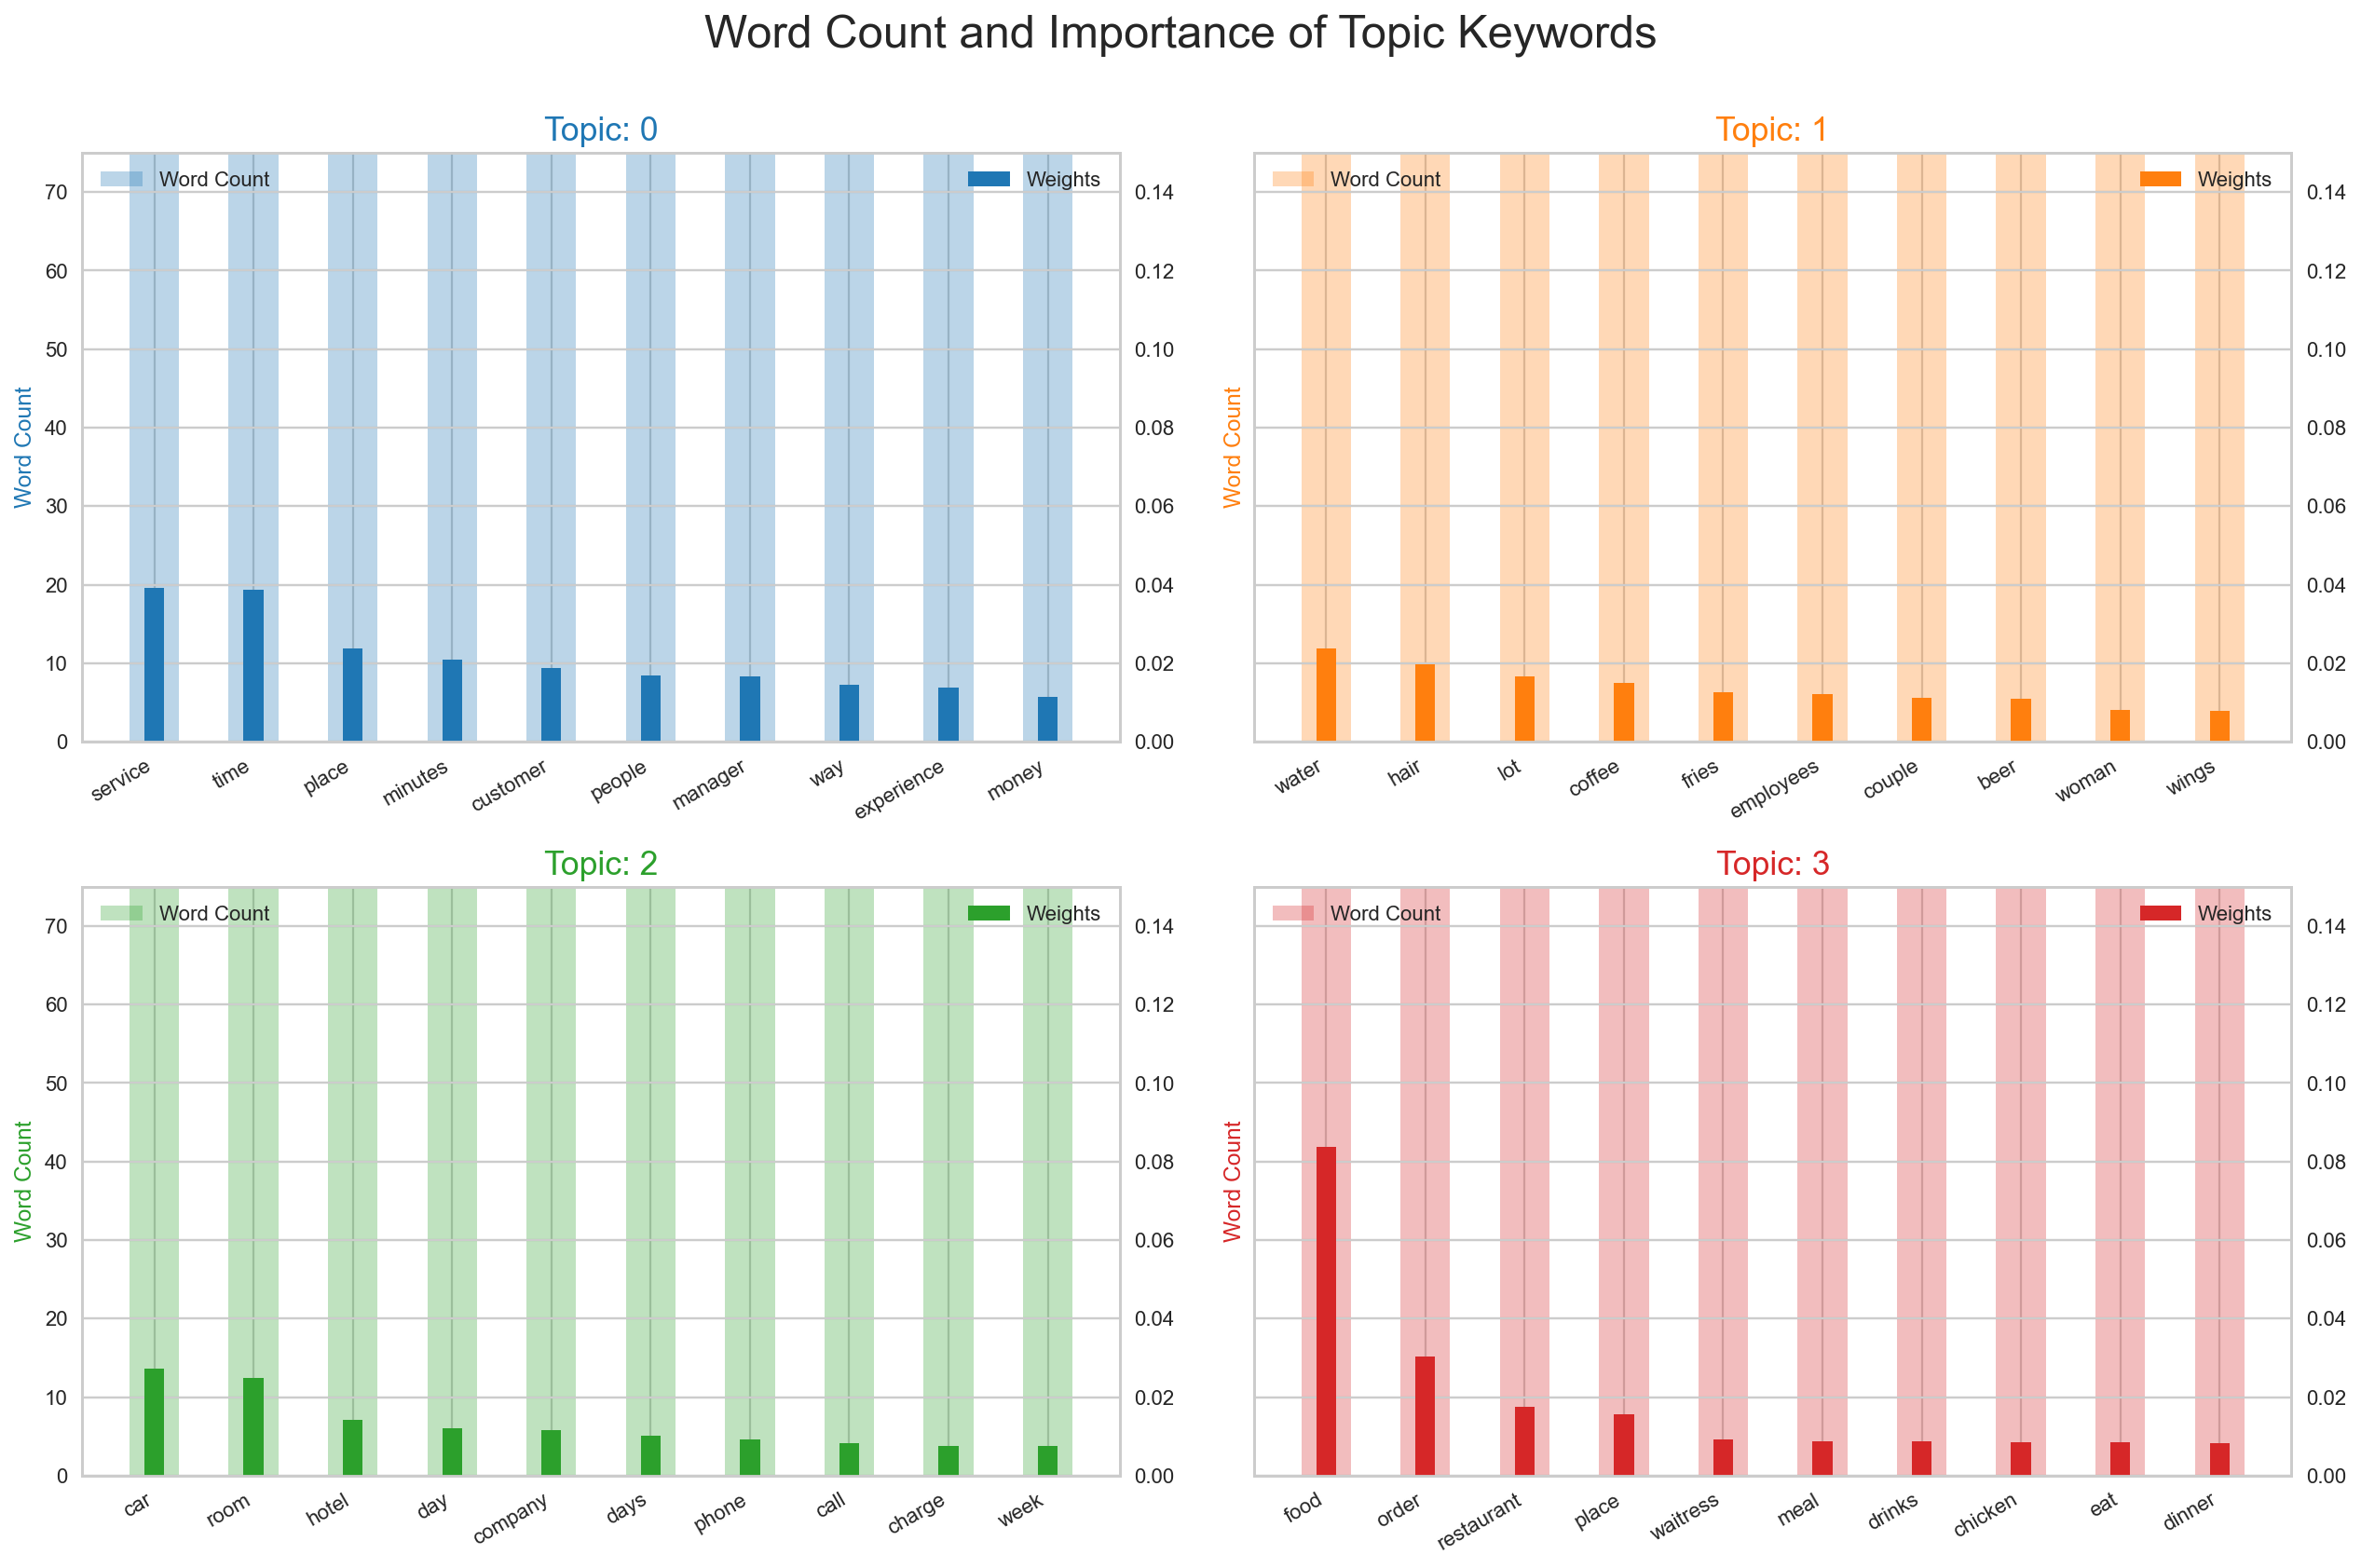

In [79]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.15); ax.set_ylim(0, 75)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

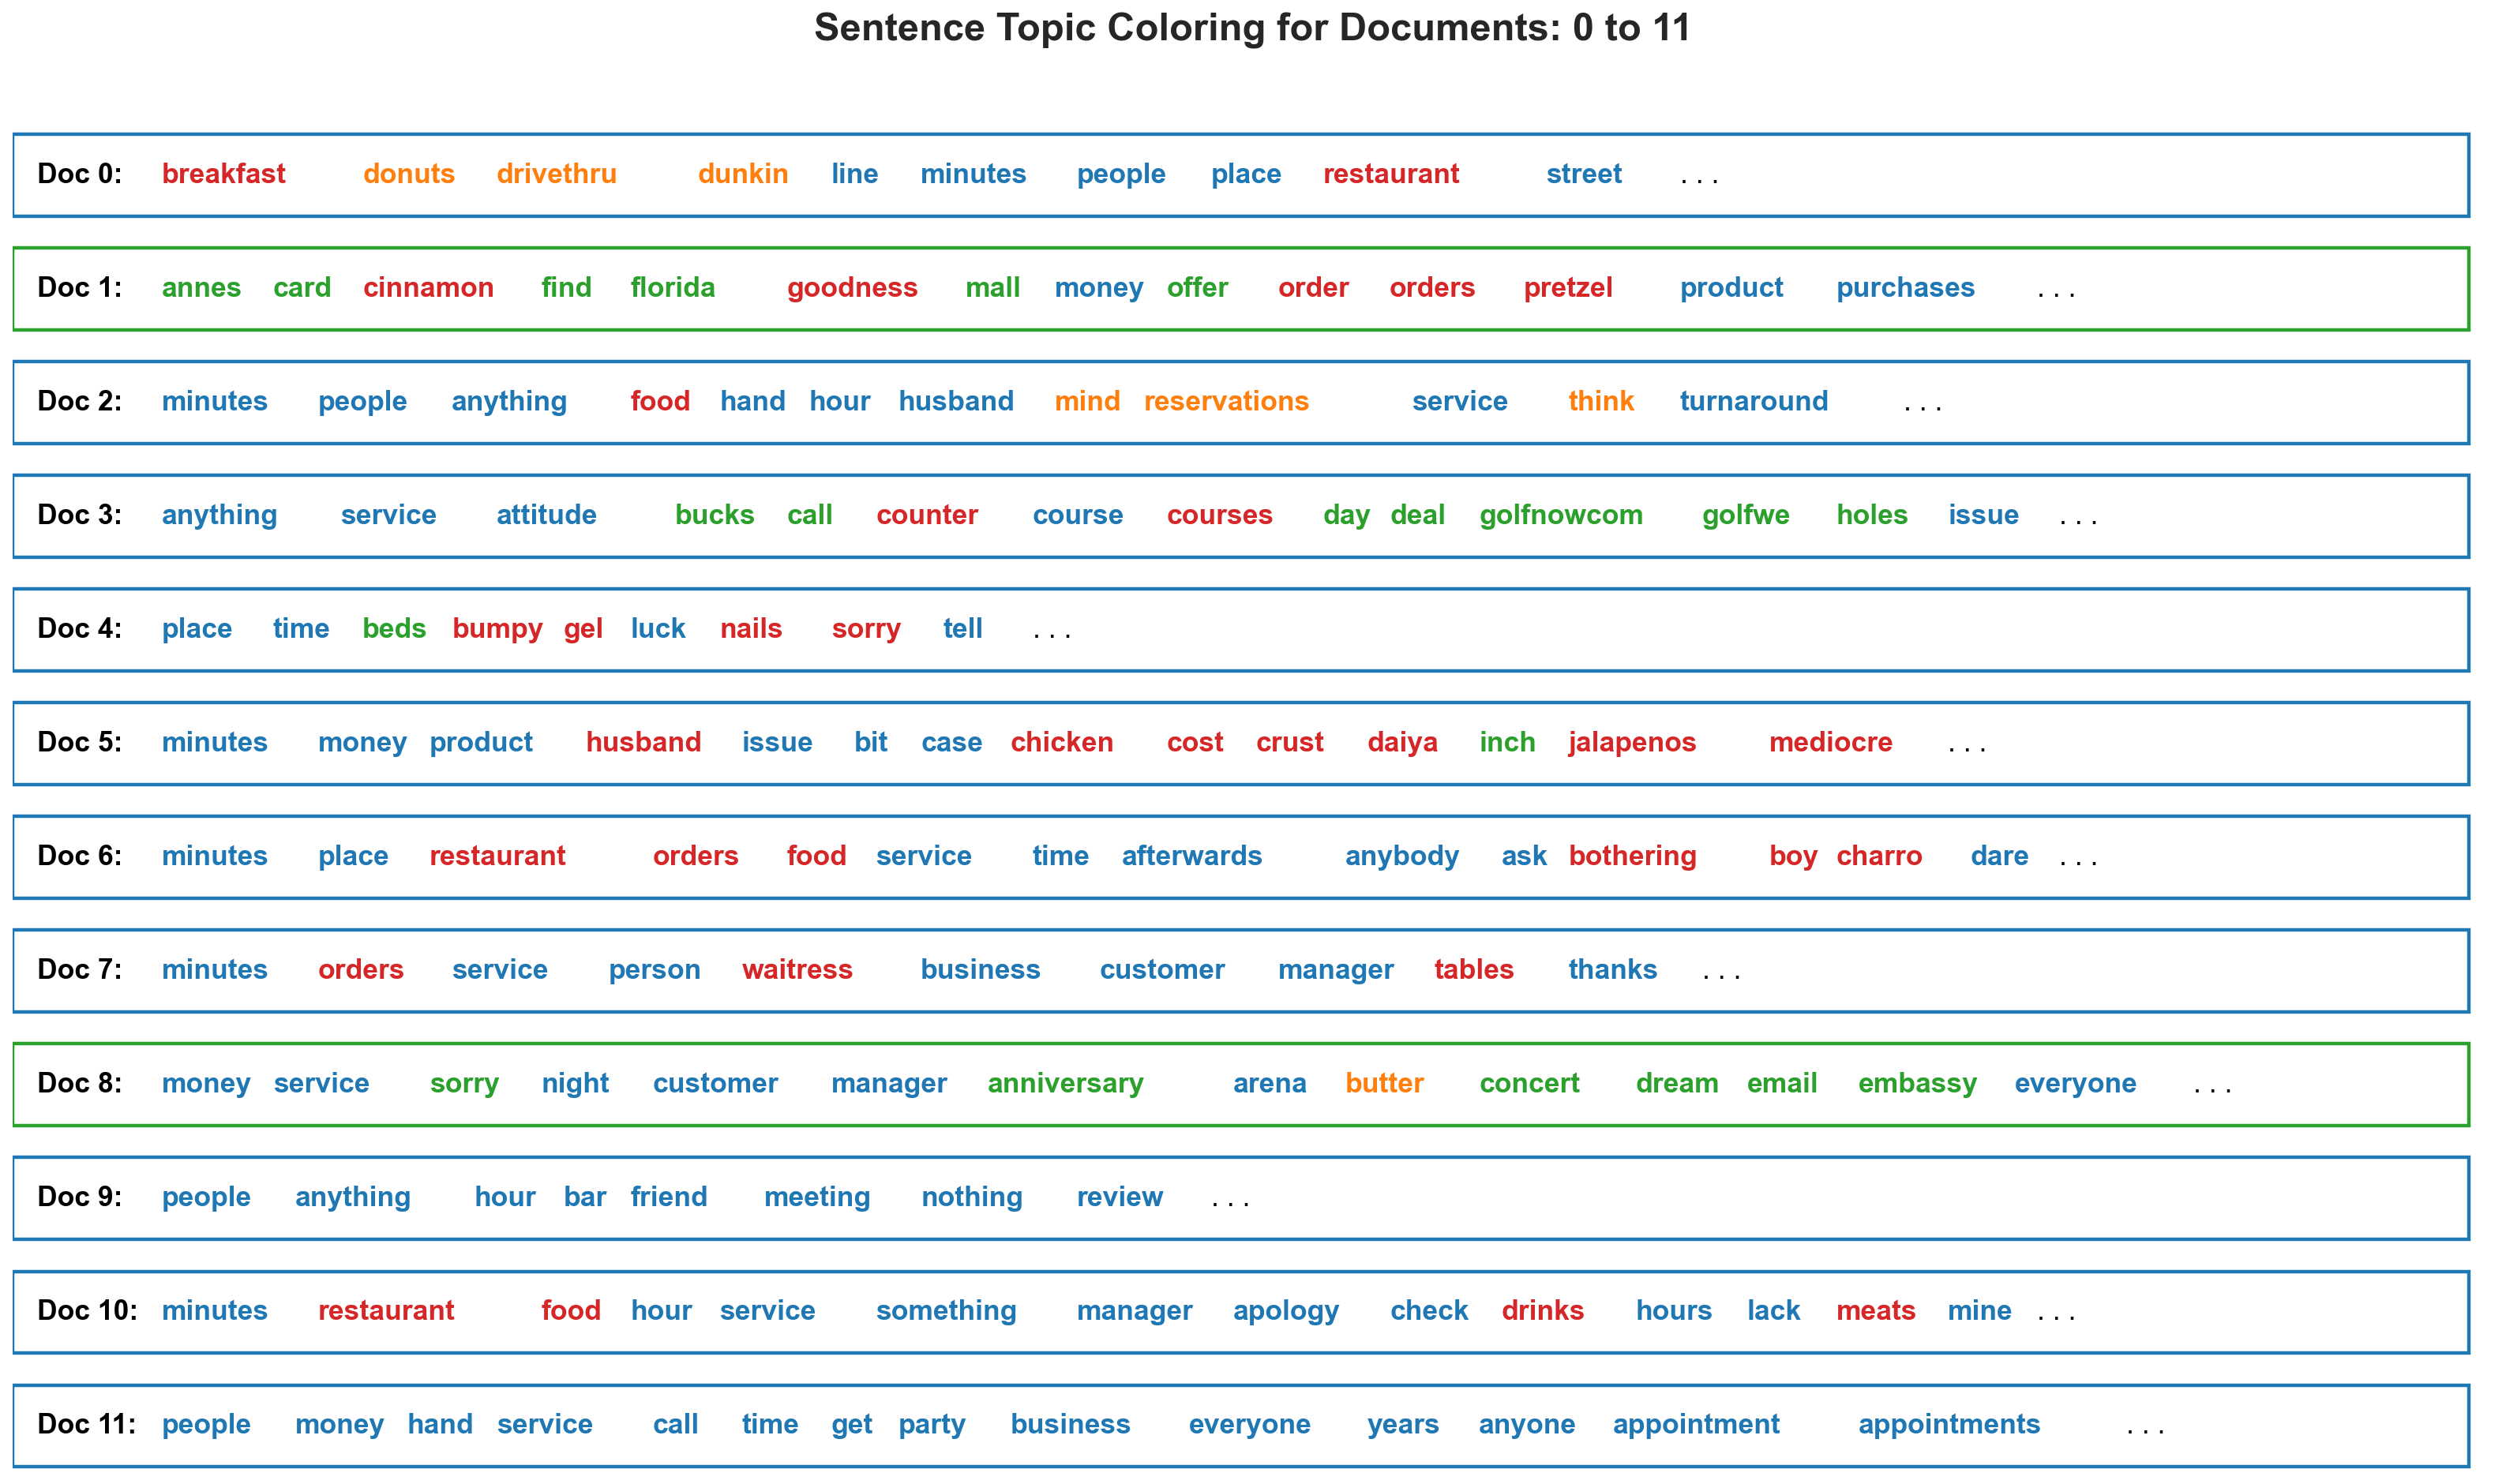

In [80]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [81]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6821 samples in 0.067s...
[t-SNE] Computed neighbors for 6821 samples in 0.163s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6821
[t-SNE] Computed conditional probabilities for sample 2000 / 6821
[t-SNE] Computed conditional probabilities for sample 3000 / 6821
[t-SNE] Computed conditional probabilities for sample 4000 / 6821
[t-SNE] Computed conditional probabilities for sample 5000 / 6821
[t-SNE] Computed conditional probabilities for sample 6000 / 6821
[t-SNE] Computed conditional probabilities for sample 6821 / 6821
[t-SNE] Mean sigma: 0.023736
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.354050
[t-SNE] KL divergence after 1000 iterations: 1.077471


Loading BokehJS ...

In [82]:
gc.collect()

69508

In [124]:
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

OSError: [Errno 22] Invalid argument

## Bert

In [101]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [4]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] I will watch Memento tonight [SEP] [PAD] [PAD]


In [102]:
import gc
gc.collect()

3565

# word2vect

In [ ]:
model = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4,
)

In [ ]:
review_text = reviews["words_token_lem"]

In [ ]:
model.build_vocab(review_text, progress_per=1000)

In [ ]:
model.train(review_text, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
model.wv.most_similar("bad")

In [ ]:
model.wv.similarity(w1="cheap", w2="inexpensive")

In [ ]:
model.wv.similarity(w1="great", w2="good")

In [ ]:
vocab = list(model.wv.key_to_index)
X = model.wv[vocab]

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [ ]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

In [ ]:
for word, pos in df.iterrows():
    ax.annotate(word, pos)

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3" # pré traitemetn du text
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [ ]:
bert_preprocess_model = hub.KerasLayer(preprocess_url) # pointeur

### K-means

df_acp2

In [83]:
df_acp2

feeling_neg  feeling_neu  feeling_pos  feeling_compound  aaa  aaand  \
8747        0.221        0.779        0.000           -0.8043    0      0   
3384        0.105        0.683        0.212            0.8257    0      0   
266         0.000        0.608        0.392            0.9735    0      0   
5875        0.175        0.656        0.169           -0.1566    0      0   
9454        0.288        0.525        0.187           -0.6542    0      0   
...           ...          ...          ...               ...  ...    ...   
6444        0.124        0.690        0.185            0.2715    0      0   
9036        0.105        0.740        0.156            0.8941    0      0   
4804        0.232        0.768        0.000           -0.8625    0      0   
9846        0.076        0.734        0.190            0.8950    0      0   
1609        0.270        0.604        0.125           -0.8906    0      0   

      aand  aaron  aarrrgghhh  aback  ...  zoneblind_tfidf  zoo_tfidf  \
8747     0      0           0      0  ...              0.0        0.0   
3384     0      0           0      0  ...              0.0        0.0   
266      0      0           0      0  ...              0.0        0.0   
5875     0      0           0      0  ...              0.0        0.0   
9454     0      0           0      0  ...              0.0        0.0   
...    ...    ...         ...    ...  ...              ...        ...   
6444     0      0           0      0  ...              0.0        0.0   
9036     0      0           0      0  ...              0.0        0.0   
4804     0      0           0      0  ...              0.0        0.0   
9846     0      0           0      0  ...              0.0        0.0   
1609     0      0           0      0  ...              0.0        0.0   

      zoom_tfidf  zorbas_tfidf  zucchini_tfidf  zuppa_tfidf  zwei_tfidf  \
8747         0.0           0.0             0.0          0.0         0.0   
3384         0.0           0.0             0.0          0.0         0.0   
266          0.0           0.0             0.0          0.0         0.0   
5875         0.0           0.0             0.0          0.0         0.0   
9454         0.0           0.0             0.0          0.0         0.0   
...          ...           ...             ...          ...         ...   
6444         0.0           0.0             0.0          0.0         0.0   
9036         0.0           0.0             0.0          0.0         0.0   
4804         0.0           0.0             0.0          0.0         0.0   
9846         0.0           0.0             0.0          0.0         0.0   
1609         0.0           0.0             0.0          0.0         0.0   

      zydeco_tfidf  zydecos_tfidf  zzzzzzzx_tfidf  
8747           0.0            0.0             0.0  
3384           0.0            0.0             0.0  
266            0.0            0.0             0.0  
5875           0.0            0.0             0.0  
9454           0.0            0.0             0.0  
...            ...            ...             ...  
6444           0.0            0.0             0.0  
9036           0.0            0.0             0.0  
4804           0.0            0.0             0.0  
9846           0.0            0.0             0.0  
1609           0.0            0.0             0.0  

[7000 rows x 36806 columns]

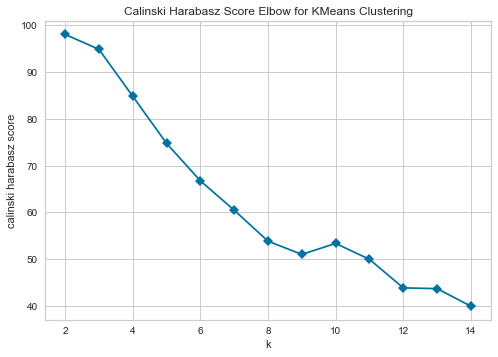

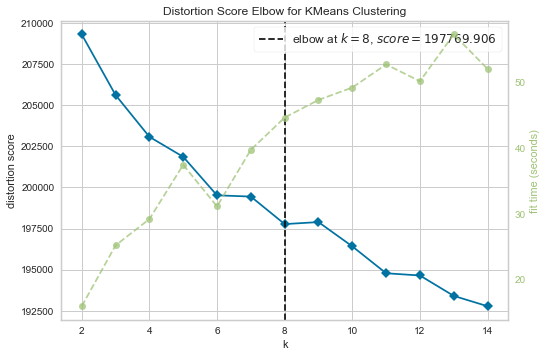

In [314]:
pk_multi_unsp.amulti_kmeans_elbow(df_acp2)

In [84]:
X = df_acp2.copy()

In [90]:
silhouette, cluster_res = pk_multi_unsp.kmsplus_iter(1, X, 8, 500, 0)

Silhouette Coefficient:  0.202936559890454  - nb clusters :  8
-----------------------------------------------------------------------------------


In [93]:
silhouette, cluster_res = pk_multi_unsp.kmsplus_iter(1, X, 5, 500, 0)

MemoryError: Unable to allocate 1.92 GiB for an array with shape (7000, 36806) and data type float64

In [6]:
gc.collect()

790

In [102]:
df_km = pk_multi_unsp.kmplus_assignclass(reviews,X, 5, 1000)

In [103]:
df_km["words_token_lem"].head(2)

8747    [dunkin, donuts, people, line, drivethru, street, minutes, people, restaurant, breakfast, place,...
3384    [shore, mall, today, florida, product, goodness, find, offer, orders, cinnamon, pretzel, annes, ...
Name: words_token_lem, dtype: object

In [390]:
df_km.head(2)

level_0                   rw_id  rw_rating  \
0     3427  3m2Z9mMC5rLcynKFCZGcsQ          1   
1    41990  6recrX_SsLVf-WjIgtCvXA          1   

                                                                                               rw_text  \
0  shocking lifetime titanium member who cares  everyone is treated like dirt at this property many...   
1  the companys incompetence  is incredible becky the one who writes reviews to all of the posts sa...   

                                                                                              new_text  \
0  shocking lifetime titanium member  cares  everyone  treated like dirt   property many restaurant...   
1   companys incompetence   incredible becky  one  writes reviews     posts saying  same thing info...   

                                                                                     text_tagged_nn_vb  \
0  shocking lifetime titanium member cares everyone treated dirt property many restaurants overblow...   
1  companys incompetence incredible becky writes reviews posts saying same thing informed img requi...   

                                                                                        words_subjects  \
0  [titanium, member, everyone, dirt, property, restaurants, number, people, conventions, service, ...   
1  [companys, incompetence, posts, thing, information, documents, appeal, claim, customer, services...   

                                                                                     words_subjects_st  \
0  titanium member everyone dirt property restaurants number people conventions service marriott pr...   
1  companys incompetence posts thing information documents appeal claim customer services informati...   

                                                                                    words_subjects_lem  \
0  titanium member everyone dirt property restaurants number people conventions service marriott pr...   
1  companys incompetence posts thing information documents appeal claim customer services informati...   

                                                                                  text_tagged_nn_vb_st  \
0  shocking lifetime titanium member cares everyone treated dirt property many restaurants overblow...   
1  companys incompetence incredible becky writes reviews posts saying same thing informed img requi...   

   ... zocdoc_tfidf  zollinger_tfidf  zollingers_tfidf  zombie_tfidf  \
0  ...          0.0              0.0               0.0           0.0   
1  ...          0.0              0.0               0.0           0.0   

   zone_tfidf zoo_tfidf  zoodles_tfidf  zoom_tfidf  zucchini_tfidf  classe  
0         0.0       0.0            0.0         0.0             0.0       0  
1         0.0       0.0            0.0         0.0             0.0       0  

[2 rows x 26613 columns]

In [391]:
df_km["classe"]

array([0, 1, 3, 4, 2])

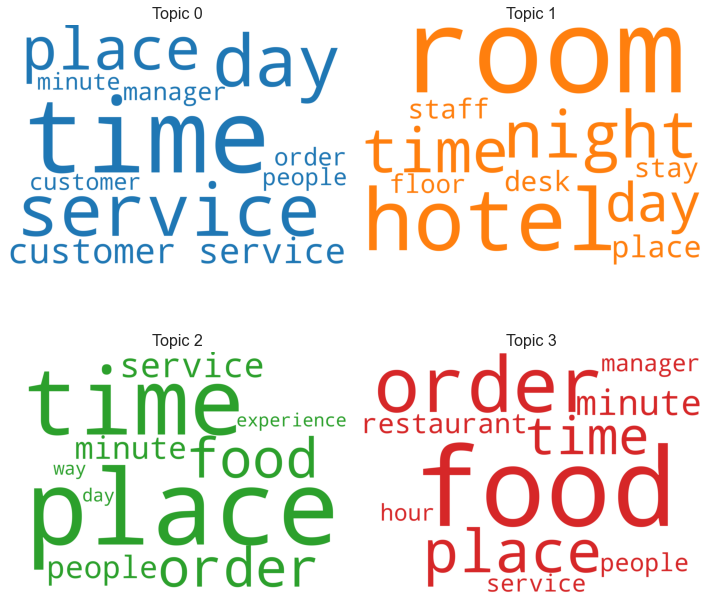

In [107]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = df_km

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = df_km["words_subjects_lem"].loc[df_km["classe"]==i]
    all_reviews = topic_words.str.cat(sep=' ')
    cloud.generate(all_reviews)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [99]:
for i in df_km.columns:
    print(i)

rw_id
rw_rating
rw_text
new_text
text_tagged_nn_vb
words_subjects
words_subjects_st
words_subjects_lem
text_tagged_nn_vb_st
text_nn_vb_lem_feels
feeling_neg
feeling_neu
feeling_pos
feeling_compound
feeling_avg
aaa
aaand
aand
aaron
aarrrgghhh
aback
abacus
abalone
abandon
abbreviate
abc
abdul
aber
aberration
abides
abilities
abilitiesi
ability
abington
abortion
abouttables
abraham
abrupt
absecent
absence
absent
absolument
absolute
absolutley
absorption
absurd
abt
abu
abundance
abundant
abura
abuse
abysmal
ac
academy
acai
accelerationwe
accent
accents
accept
acceptablewill
acceptance
accepting
accepts
access
accessibility
accessories
accessory
accident
accidentnew
accidents
accommodate
accommodating
accommodation
accommodations
accomodate
accomodating
accompaniments
accomplishment
accord
account
accountability
accounti
accounts
accross
acct
accuracy
accurate
accusation
accusatory
accuse
accustom
ace
aces
acetone
ache
aches
acid
acidity
acknowledge
acknowledged
acknowledgement
acknowledges

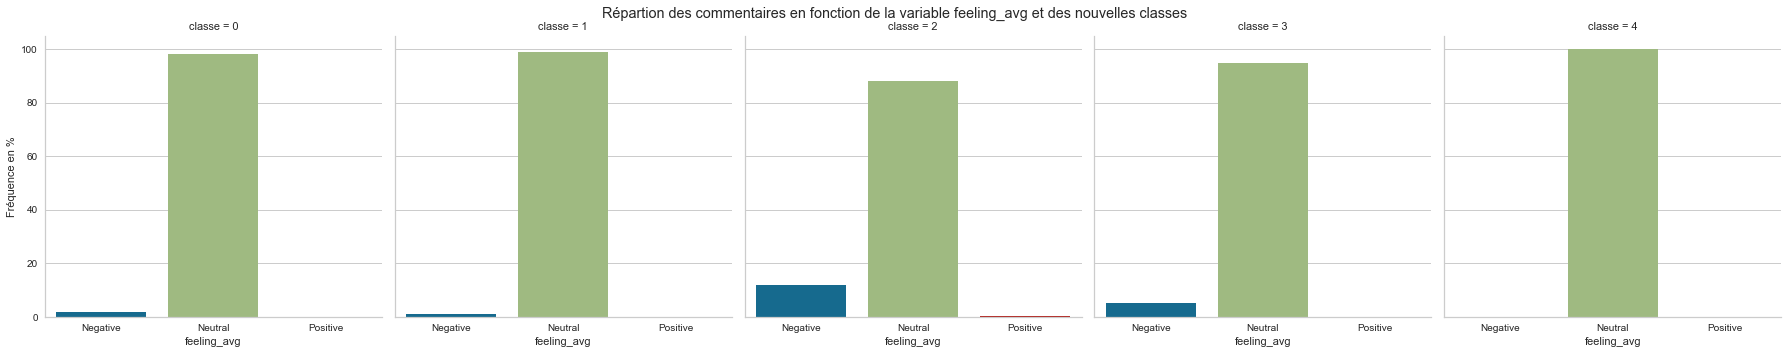

In [108]:
t = pd.crosstab(df_km.feeling_avg,
                df_km.classe,
                normalize="columns")
t = t.assign(feeling_avg=t.index)
tm = pd.melt(t, id_vars="feeling_avg")
tm = tm.assign(value=100 * tm.value)
ax=sns.catplot(x="feeling_avg",
               y="value", 
               col="classe",
               data=tm,
               kind="bar")
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle("Répartion des commentaires en fonction de la variable feeling_avg et des nouvelles classes")
ax.set_axis_labels("feeling_avg","Fréquence en %")
plt.show()

# Bert

In [376]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

SystemError: GPU device not found

In [377]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading: 100%|██████████| 226k/226k [00:00<00:00, 2.94MB/s]
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 9.36kB/s]
Downloading: 100%|██████████| 570/570 [00:00<00:00, 13.0kB/s]


In [378]:
reviews.head(2)

rw_id  rw_rating  \
0  3m2Z9mMC5rLcynKFCZGcsQ          1   
1  6recrX_SsLVf-WjIgtCvXA          1   

                                                                                               rw_text  \
0  shocking lifetime titanium member who cares  everyone is treated like dirt at this property many...   
1  the companys incompetence  is incredible becky the one who writes reviews to all of the posts sa...   

                                                                                              new_text  \
0  shocking lifetime titanium member  cares  everyone  treated like dirt   property many restaurant...   
1   companys incompetence   incredible becky  one  writes reviews     posts saying  same thing info...   

                                                                                     text_tagged_nn_vb  \
0  shocking lifetime titanium member cares everyone treated dirt property many restaurants overblow...   
1  companys incompetence incredible becky writes reviews posts saying same thing informed img requi...   

                                                                                        words_subjects  \
0  [titanium, member, everyone, dirt, property, restaurants, number, people, conventions, service, ...   
1  [companys, incompetence, posts, thing, information, documents, appeal, claim, customer, services...   

                                                                                     words_subjects_st  \
0  titanium member everyone dirt property restaurants number people conventions service marriott pr...   
1  companys incompetence posts thing information documents appeal claim customer services informati...   

                                                                                    words_subjects_lem  \
0  titanium member everyone dirt property restaurants number people conventions service marriott pr...   
1  companys incompetence posts thing information documents appeal claim customer services informati...   

                                                                                  text_tagged_nn_vb_st  \
0  shocking lifetime titanium member cares everyone treated dirt property many restaurants overblow...   
1  companys incompetence incredible becky writes reviews posts saying same thing informed img requi...   

                                                                                  text_nn_vb_lem_feels  \
0  shocking lifetime titanium member cares everyone treated dirt property many restaurants overblow...   
1  companys incompetence incredible becky writes reviews posts saying same thing informed img requi...   

   ...  zits_tfidf  zocdoc_tfidf  zollinger_tfidf  zollingers_tfidf  \
0  ...         0.0           0.0              0.0               0.0   
1  ...         0.0           0.0              0.0               0.0   

  zombie_tfidf  zone_tfidf  zoo_tfidf  zoodles_tfidf  zoom_tfidf  \
0          0.0         0.0        0.0            0.0         0.0   
1          0.0         0.0        0.0            0.0         0.0   

   zucchini_tfidf  
0             0.0  
1             0.0  

[2 rows x 26611 columns]

In [382]:
reviews["input_ids"] = reviews["words_subjects_lem"].progress_apply(lambda x: tokenizer.encode(x))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [383]:
reviews['attention_mask'] =  reviews["words_subjects_lem"].progress_apply(lambda x: tokenizer.encode_plus(
                                                                                                              x,                      # Sentence to encode.
                                                                                                              add_special_tokens 
                                                                                                              = True, # Add '[CLS]' and '[SEP]'
                                                                                                              max_length = 64,           # Pad & truncate all sentences.
                                                                                                              pad_to_max_length = True,
                                                                                                              return_attention_mask = True,   # Construct attn. masks.
                                                                                                              return_tensors = 'pt',     # Return pytorch tensors.
                                                                                                         ))




  0%|          | 0/5000 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [385]:
import torch
# Convert the lists into tensors.
input_ids = torch.cat(reviews["input_ids"], dim=0)
attention_masks = torch.cat(reviews["attention_masks"], dim=0)
labels = torch.tensor(reviews["words_subjects_lem"])

TypeError: cat() received an invalid combination of arguments - got (Series, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [ ]:
# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [386]:
reviews["encoded_"] = reviews["words_subjects_lem"].progress_apply(lambda x:  tokenizer(x, return_tensors='pt'))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [387]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")


Downloading: 100%|██████████| 420M/420M [00:07<00:00, 58.0MB/s] 
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [388]:
reviews["info_"] = reviews["encoded_"].progress_apply(lambda x: model(**x))

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [389]:
reviews.head(2)

rw_id  rw_rating  \
0  3m2Z9mMC5rLcynKFCZGcsQ          1   
1  6recrX_SsLVf-WjIgtCvXA          1   

                                                                                               rw_text  \
0  shocking lifetime titanium member who cares  everyone is treated like dirt at this property many...   
1  the companys incompetence  is incredible becky the one who writes reviews to all of the posts sa...   

                                                                                              new_text  \
0  shocking lifetime titanium member  cares  everyone  treated like dirt   property many restaurant...   
1   companys incompetence   incredible becky  one  writes reviews     posts saying  same thing info...   

                                                                                     text_tagged_nn_vb  \
0  shocking lifetime titanium member cares everyone treated dirt property many restaurants overblow...   
1  companys incompetence incredible becky writes reviews posts saying same thing informed img requi...   

                                                                                        words_subjects  \
0  [titanium, member, everyone, dirt, property, restaurants, number, people, conventions, service, ...   
1  [companys, incompetence, posts, thing, information, documents, appeal, claim, customer, services...   

                                                                                     words_subjects_st  \
0  titanium member everyone dirt property restaurants number people conventions service marriott pr...   
1  companys incompetence posts thing information documents appeal claim customer services informati...   

                                                                                    words_subjects_lem  \
0  titanium member everyone dirt property restaurants number people conventions service marriott pr...   
1  companys incompetence posts thing information documents appeal claim customer services informati...   

                                                                                  text_tagged_nn_vb_st  \
0  shocking lifetime titanium member cares everyone treated dirt property many restaurants overblow...   
1  companys incompetence incredible becky writes reviews posts saying same thing informed img requi...   

                                                                                  text_nn_vb_lem_feels  \
0  shocking lifetime titanium member cares everyone treated dirt property many restaurants overblow...   
1  companys incompetence incredible becky writes reviews posts saying same thing informed img requi...   

   ...  zollingers_tfidf  zombie_tfidf  zone_tfidf  zoo_tfidf zoodles_tfidf  \
0  ...               0.0           0.0         0.0        0.0           0.0   
1  ...               0.0           0.0         0.0        0.0           0.0   

   zoom_tfidf  zucchini_tfidf  \
0         0.0             0.0   
1         0.0             0.0   

                                                                                             input_ids  \
0          [101, 23431, 2266, 3071, 6900, 3200, 7884, 2193, 2111, 12472, 2326, 26490, 3200, 2729, 102]   
1  [101, 2194, 2015, 4297, 25377, 12870, 5897, 8466, 2518, 2592, 5491, 5574, 4366, 8013, 2578, 2592...   

                                attention_mask  \
0  [input_ids, token_type_ids, attention_mask]   
1  [input_ids, token_type_ids, attention_mask]   

                                      encoded_  
0  [input_ids, token_type_ids, attention_mask]  
1  [input_ids, token_type_ids, attention_mask]  

[2 rows x 26614 columns]

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(encoding, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

# Classement des Photos

In [294]:
photos_json.head(2)

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   

                                             caption    label  \
0  Nice rock artwork everywhere and craploads of ...   inside   
1                                                     outside   

                                               photo  
0  input\yelp_photos\photos\zsvj7vloL4L5jhYyPIuVw...  
1  input\yelp_photos\photos\HCUdRJHHm_e0OCTlZetGL...

In [73]:
photos_json["photo"] = "input\\yelp_photos\\photos\\" + photos_json["photo_id"] + ".jpg"

In [529]:
photos_json.head(2)

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   

                                             caption    label  \
0  Nice rock artwork everywhere and craploads of ...   inside   
1                                                     outside   

                                               photo  
0  input\yelp_photos\photos\zsvj7vloL4L5jhYyPIuVw...  
1  input\yelp_photos\photos\HCUdRJHHm_e0OCTlZetGL...

In [297]:
photos_json.shape

(100, 5)

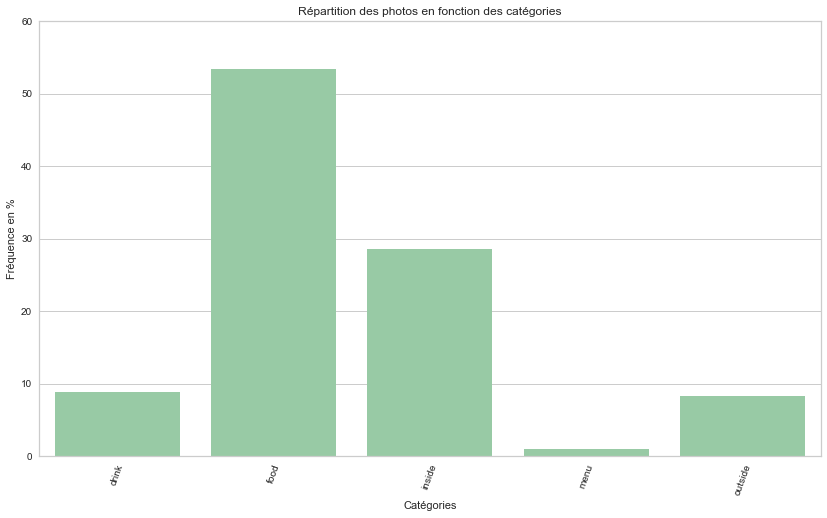

In [530]:
pk.graph_barplot(photos_json['label'],
                  "Répartition des photos en fonction des catégories", 
                   (0.564, 0.823, 0.631),
                   0, 60, "Catégories", "Fréquence en %",70, 1, (14,8))

In [80]:
list_photos = photos_json["photo"]

In [81]:
data = photos_json.copy()

Regardons 2 images par catégorie.

drink


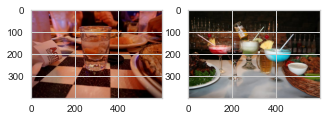

food


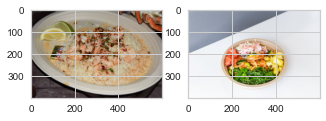

inside


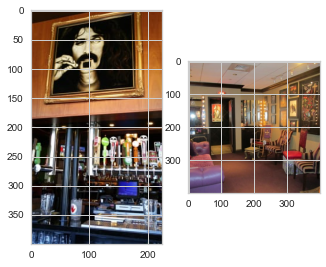

menu


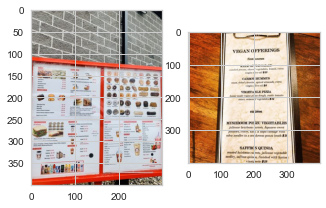

outside


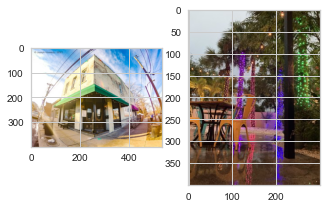

In [25]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [data["photo"][i] for i in range(len(data)) if data["label"][i]==name]
    return list_image_name

list_labels = ["drink", "food", "inside", "menu", "outside"]
list_drink=[list_photos[i] for i in range(len(data)) if data["label"][i]=="drink"]
list_food=[list_photos[i] for i in range(len(data)) if data["label"][i]=="food"]
list_inside=[list_photos[i] for i in range(len(data)) if data["label"][i]=="inside"]
list_menu=[list_photos[i] for i in range(len(data)) if data["label"][i]=="menu"]
list_outside=[list_photos[i] for i in range(len(data)) if data["label"][i]=="outside"]

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(2):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

Les images sont en couleur et de tailles différentes. Il convient donc de les mettre en gris et toutes à la même échelle.
Nous allons aussi améliorer le contraste, pour cela nous créons une fonction.

In [109]:
photos.head(2)

test = photos.head(1)

In [346]:
link = test["photos"]

In [348]:
link[0]

"['https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg']"

In [350]:
import urllib.request

print('Beginning file download with urllib2...')

url = "https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg"


urllib.request.urlretrieve(url, 'input/download_photos/photo1.jpg')

Beginning file download with urllib2...


('input/download_photos/photo1.jpg',
 <http.client.HTTPMessage at 0x1d59300fa60>)

In [14]:
image = io.imread('input/download_photos/photo1.jpg')

In [3]:
# informations
print( 'classe :', type(image) )
print( 'type :', image.dtype )
print( 'taille :', image.shape )

classe : <class 'numpy.ndarray'>
type : uint8
taille : (750, 1000, 3)


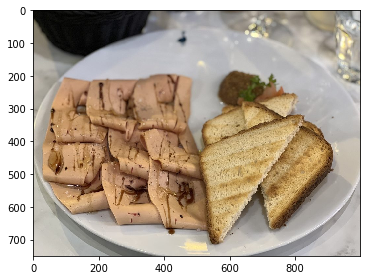

In [4]:
io.imshow(image)
io.show()

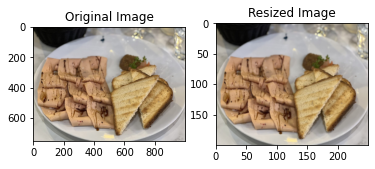

In [52]:

img_resized = resize(image, (200, 250))

#plot images
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(img_resized)
plt.title('Resized Image')
plt.show()

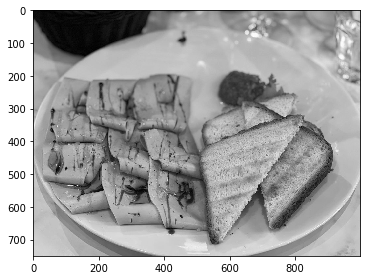

In [20]:
grey_image = color.rgb2gray( image )
io.imshow( grey_image )
io.show()

In [36]:
grey_image = grey_image*256

In [37]:
grey_image

array([[  5.94733176,   9.96301804,  13.97870431, ..., 199.27552   ,
        199.27552   , 199.27552   ],
       [  7.9551749 ,  10.96693961,  13.97870431, ..., 199.27552   ,
        199.27552   , 199.27552   ],
       [ 11.97086118,  12.97478275,  13.97870431, ..., 199.27552   ,
        199.27552   , 199.27552   ],
       ...,
       [209.44805647, 209.44805647, 209.44805647, ..., 195.39696941,
        195.39696941, 196.40089098],
       [209.44805647, 209.44805647, 209.44805647, ..., 194.39304784,
        195.39696941, 195.39696941],
       [209.44805647, 209.44805647, 209.44805647, ..., 194.39304784,
        194.39304784, 195.39696941]])

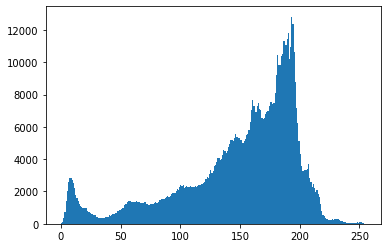

In [38]:
# Charger l'image comme matrice de pixels
img = np.array(grey_image)

# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(img.flatten(), bins=range(256))
plt.show()

In [15]:
from skimage import exposure

img_corrected = exposure.equalize_hist(grey_image)

NameError: name 'grey_image' is not defined

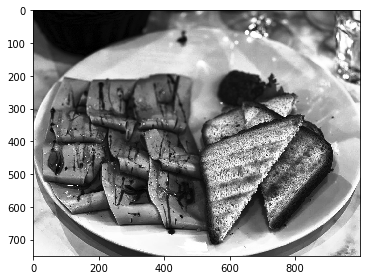

In [40]:
io.imshow(img_corrected)
io.show()

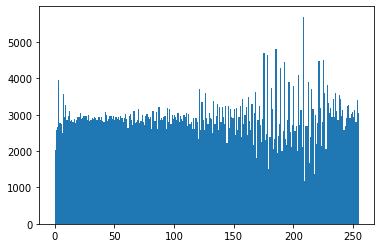

In [43]:
# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True

img = np.array(img_corrected*256)
n, bins, patches = plt.hist(img.flatten(), bins=range(256))
plt.show()

Nous créons une fonction pour mettre toutes les images à la même échelle, mais aussi pour les mettre en gris et égaliser le contrate.

In [361]:
from skimage.transform import resize
from skimage import exposure

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import io

from skimage import color, img_as_ubyte, img_as_float32
from numpy import expand_dims

In [440]:
from keras import backend as K

def grayscale_to_rgb(images, channel_axis=-1):
    images= K.expand_dims(images, axis=channel_axis)
    tiling = [1] * 4    # 4 dimensions: B, H, W, C
    tiling[channel_axis] *= 3
    images= K.tile(images, tiling)
    return images

In [30]:
#200, 250
def clean_image(link_image, grey, float_img, size_l=224, size_h=224):
    try:
        image = io.imread(link_image)
        img_resized = resize(image, (size_l, size_h))
        if grey == 1:
            grey_image = color.rgb2gray( img_resized )
            img_corrected = exposure.equalize_hist(grey_image)
        else:
            img_corrected = exposure.equalize_hist(img_resized)
        if float_img == 1:
            img_corrected = img_as_ubyte(img_corrected)
        elif float_img == 2:
            #img_corrected = color.gray2rgb(img_corrected)
            img_corrected = img_to_array(img_corrected)
        return img_corrected
    except:
        return None
    

In [58]:
data["img_corrected"] = data["photo"].progress_apply(lambda x: clean_image(x, 1, 1, 224, 224))

  0%|          | 0/100 [00:00<?, ?it/s]

In [82]:
data["img_corrected_float"] = data["photo"].progress_apply(lambda x: clean_image(x, 0, 2, 224, 224))

  0%|          | 0/2000 [00:00<?, ?it/s]

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\skimage\_shared\utils.py:338: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


In [85]:
data = data.loc[pd.isnull(data["img_corrected_float"]) != True]

In [86]:
data.shape

(1999, 6)

In [87]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data["label_num"] = le.fit_transform(data["label"])

In [88]:
data.head(2)

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   

                                             caption    label  \
0  Nice rock artwork everywhere and craploads of ...   inside   
1                                                     outside   

                                               photo  \
0  input\yelp_photos\photos\zsvj7vloL4L5jhYyPIuVw...   
1  input\yelp_photos\photos\HCUdRJHHm_e0OCTlZetGL...   

                                 img_corrected_float  label_num  
0  [[[0.43349215, 0.2857065, 0.06813415], [0.4334...          2  
1  [[[0.70247084, 0.78909767, 0.8848647], [0.6254...          4

In [629]:
data["img_corrected_float"][0].shape

(224, 224, 3)

In [89]:
import dill
#dill.dump_session('notebook_envimg_4.db')

TypeError: cannot pickle 'generator' object

In [7]:
import dill
dill.load_session('notebook_envimg_4.db')

rotation + flou ????????????

In [8]:
from PIL import ImageFilter
import cv2
# Appliquer le lissage par moyennage (fenêtre de taille 9) et afficher le résultat
#noisy_img.filter(ImageFilter.BoxBlur(1)).show()

In [630]:
photo_test = data["img_corrected_float"].head(1)

In [631]:
photo_test

0    [[[0.43349214068056996, 0.2857064842546141, 0....
Name: img_corrected_float, dtype: object

TypeError: Image data of dtype object cannot be converted to float

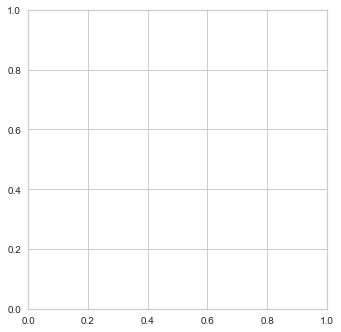

In [632]:
plt.imshow(photo_test)

In [94]:
gray1 = photo_test[0].copy()

In [95]:
gray1

array([[ 74,  74,  74, ..., 122, 122, 127],
       [ 74,  74,  74, ..., 124, 124, 131],
       [ 74,  74,  74, ..., 126, 127, 134],
       ...,
       [140, 161, 173, ...,  63,  65,  62],
       [177, 169, 190, ...,  64,  61,  73],
       [174, 173, 167, ...,  64,  70,  69]], dtype=uint8)

In [621]:
plt.imshow(img_as_ubyte(photo_test))

ValueError: Cannot convert from object to uint8.

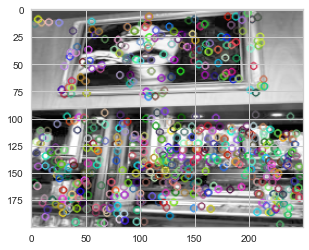

In [96]:
#keypoints
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(gray1,None)

img_1 = cv2.drawKeypoints(gray1,keypoints_1,gray1)
plt.imshow(img_1)

In [137]:
descriptors_1

array([[  1.,   0.,   0., ...,   0.,   3.,  26.],
       [ 73.,  14.,   0., ...,   0.,   0.,   0.],
       [ 35.,  18.,   2., ...,  20.,   5.,   2.],
       ...,
       [  6.,  77.,  82., ...,   1.,  18.,   2.],
       [  0.,   2.,   0., ...,  14.,  41., 126.],
       [ 12.,  13.,  30., ...,   0.,   0.,   0.]], dtype=float32)

In [139]:
len(descriptors_1)

619

In [107]:
data.shape

(100, 6)

In [29]:
sift_keypoints = []
sift_keypoints_all = []

In [35]:
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image in data["img_corrected"] :
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")


Nombre de descripteurs :  (44704, 128)
temps de traitement SIFT descriptor :             1.93 secondes


D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [36]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

####score ARI

Nombre de clusters estimés :  211
Création de 211 clusters de descripteurs ...


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


temps de traitement kmeans :             5.54 secondes


In [37]:
gc.collect()

23

In [38]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
temps de création histogrammes :             0.36 secondes


# Pca

100
[1.51388098e+01 1.18010924e+01 9.01811944e+00 8.27558682e+00
 6.34749930e+00 5.73926994e+00 5.29035226e+00 5.21587305e+00
 4.80931316e+00 4.66787635e+00 4.50760067e+00 4.18065304e+00
 4.04835682e+00 3.65948661e+00 3.58496773e+00 3.47954454e+00
 3.38066944e+00 3.25903570e+00 3.23235913e+00 3.13885786e+00
 3.08550811e+00 2.96721535e+00 2.90128599e+00 2.86317621e+00
 2.81578533e+00 2.76360451e+00 2.62037465e+00 2.60234563e+00
 2.52608728e+00 2.44548452e+00 2.38414063e+00 2.30136025e+00
 2.25767819e+00 2.19867764e+00 2.12430663e+00 2.09250674e+00
 2.06751893e+00 2.02509100e+00 1.96811763e+00 1.89854735e+00
 1.85873735e+00 1.79675218e+00 1.75734168e+00 1.71130717e+00
 1.64420328e+00 1.63403174e+00 1.56129206e+00 1.52192788e+00
 1.46389264e+00 1.44616452e+00 1.42619881e+00 1.35554420e+00
 1.33238590e+00 1.26953978e+00 1.26276455e+00 1.23386010e+00
 1.18844908e+00 1.13471684e+00 1.12354111e+00 1.06748480e+00
 1.04363139e+00 1.03935487e+00 9.77036672e-01 9.53952052e-01
 9.20378194e-01 9.02

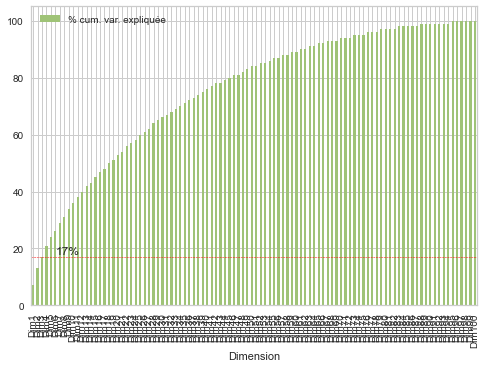

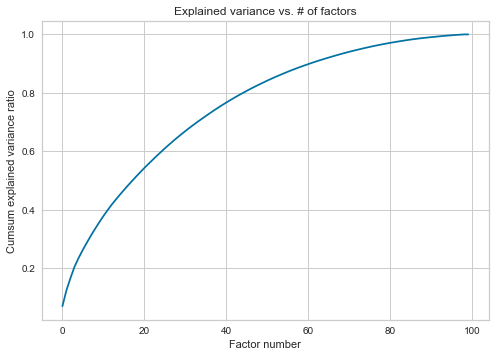

In [23]:
Z = pk_multi.amulti_acp_standard(im_features)
pk_multi.amulti_acp_choice_dim(im_features, Z)

In [24]:
im_features

array([[0.00598802, 0.00598802, 0.        , ..., 0.00399202, 0.00598802,
        0.00798403],
       [0.002     , 0.004     , 0.006     , ..., 0.        , 0.        ,
        0.002     ],
       [0.        , 0.018     , 0.002     , ..., 0.        , 0.006     ,
        0.        ],
       ...,
       [0.0060241 , 0.00301205, 0.        , ..., 0.        , 0.00903614,
        0.0060241 ],
       [0.        , 0.00653595, 0.00217865, ..., 0.        , 0.00653595,
        0.0043573 ],
       [0.        , 0.00699301, 0.        , ..., 0.        , 0.        ,
        0.00699301]])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


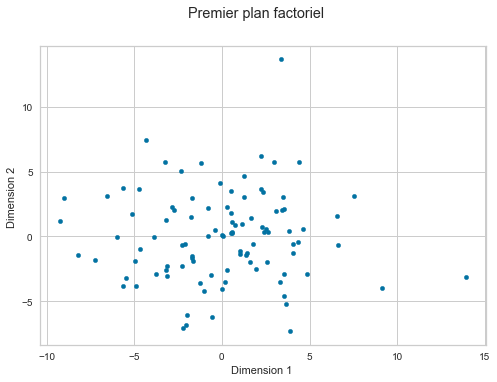

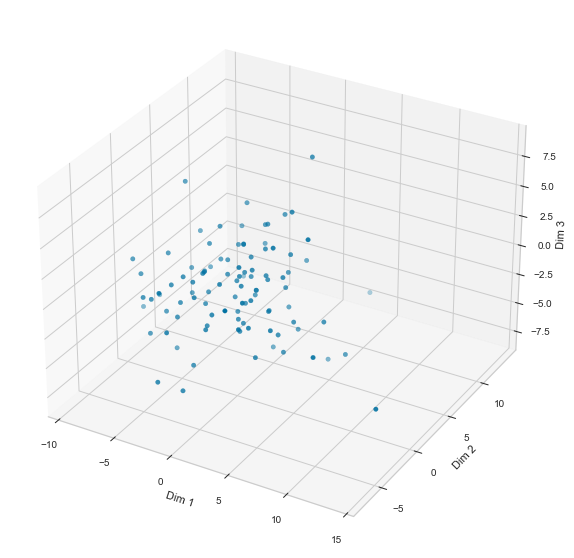

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [26]:

#pk.amultiacp_visualizer(df_acp2, Z, 3, df_acp,df_acp["customer_unique_id"], df_acp["order_id_size"], "order_id_size")
pk_multi.amultiacp_visualizer(im_features, Z, 3, im_features, data["label"], data["label"], "label",0)

In [32]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

# graph

Dimensions dataset avant réduction PCA :  (100, 211)
Dimensions dataset après réduction PCA :  (100, 88)


In [35]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label"]
print(df_tsne.shape)

(100, 3)


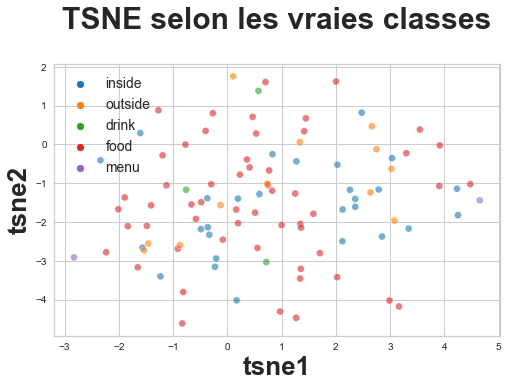

In [36]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [37]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=5, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(100, 4)


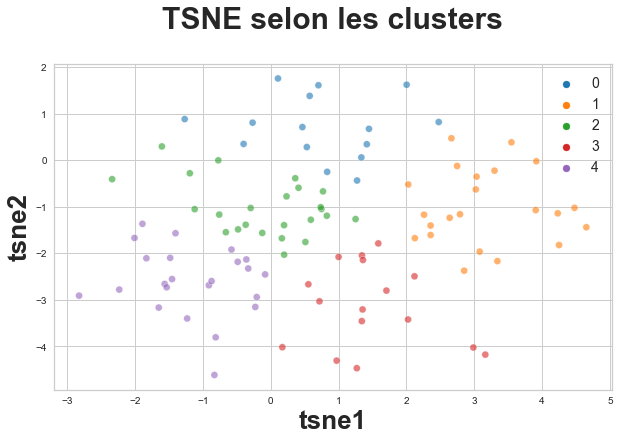

ARI :  0.028251923404183303


In [39]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label_num"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [40]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    15
1    22
2    24
3    16
4    23
Name: class, dtype: int64

In [41]:
conf_mat = metrics.confusion_matrix(data["label_num"], cls.labels_)
print(conf_mat)

[[ 1  0  1  1  0]
 [ 9  5 16 13 12]
 [ 3 11  5  2  7]
 [ 0  1  0  0  1]
 [ 2  5  2  0  3]]


In [42]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [4, 3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [4, 3, 1, 2, 0]
[[ 0  1  1  0  1]
 [12 16 13  5  9]
 [ 7  5  2 11  3]
 [ 1  0  0  1  0]
 [ 3  2  0  5  2]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.67      0.29      0.41        55
           2       0.12      0.07      0.09        28
           3       0.05      0.50      0.08         2
           4       0.13      0.17      0.15        12

    accuracy                           0.21       100
   macro avg       0.19      0.21      0.15       100
weighted avg       0.42      0.21      0.27       100



<AxesSubplot:>

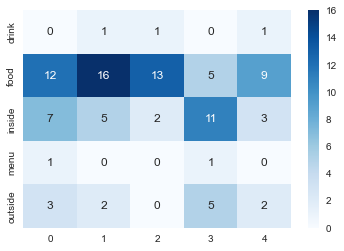

In [43]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# Resnet50

In [90]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

# false pour supprbimer la dernière couche uqi sert de classification
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [40]:
def make_model():
    # our model is based on MobileNet, but we load only the layers before the classification
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 1))
    # This loop below is needed to tell to Keras that we don t want to retrain our base model
    for layer in base_model.layers:
            layer.trainable=False

    # below, we define our own layers to perform our binary classification Cats vs. Dogs
    num_classes = 2
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax', name='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)

    return model

Nous créons maintenant notre modèle à l'aide de l'apprentissage par transfert à l'aide de ResNet50 pré-formé en ajoutant notre propre couche entièrement connectée et le classificateur final à l'aide de la fonction d'activation sigmoïde.

In [689]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=(224,224,3)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()

D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        (None, 100352)            23587712  
                                                                 
 dense_33 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 513       
                                                                 
Total params: 75,231,617
Trainable params: 51,643,905

In [91]:
gc.collect()

1635

In [42]:
data.head(2)

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   

                                             caption    label  \
0  Nice rock artwork everywhere and craploads of ...   inside   
1                                                     outside   

                                               photo  \
0  input\yelp_photos\photos\zsvj7vloL4L5jhYyPIuVw...   
1  input\yelp_photos\photos\HCUdRJHHm_e0OCTlZetGL...   

                                       img_corrected  \
0  [[75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, ...   
1  [[210, 202, 183, 167, 161, 156, 162, 169, 176,...   

                                 img_corrected_float  label_num  
0  [[0.2945932, 0.2945932, 0.2945932, 0.2945932, ...          2  
1  [[0.825089, 0.7912848, 0.71600354, 0.6529926, ...          4

In [43]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 224, 224, 3) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
model (None, 224, 224, 3) float32
dense (None, 100352) float32
dropout (None, 512) float32
dense_1 (None, 512) float32


[None, None, None, None]

In [92]:
X = data["img_corrected_float"]

In [93]:
Y = data["label_num"]

In [94]:
X_train, X_test, y_train, y_test = pk_multi_sup.pipelineModel_TrainingSet(X,Y, 0, 0)

In [95]:
from keras.preprocessing.image import img_to_array

In [96]:
gc.collect()

0

In [97]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img


In [116]:

train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
 horizontal_flip=True, fill_mode='nearest')

In [117]:
val_datagen = ImageDataGenerator()

In [100]:
X_keras = list(X)

In [101]:
X_keras_2 = np.array(X_keras)

In [102]:
gc.collect()

0

In [103]:
t = list(X_test)

In [104]:
x_test = np.array(t)

In [105]:
x_test.shape

(600, 224, 224, 3)

In [106]:
del t

In [107]:
t = list(X_train)

In [108]:
x_train = np.array(t)

In [109]:
x_train.shape

(1399, 224, 224, 3)

In [118]:
train_generator = train_datagen.flow(x_train, y_train)

In [119]:
test_generator = val_datagen.flow(x_test, y_test)

In [112]:
gc.collect()

0

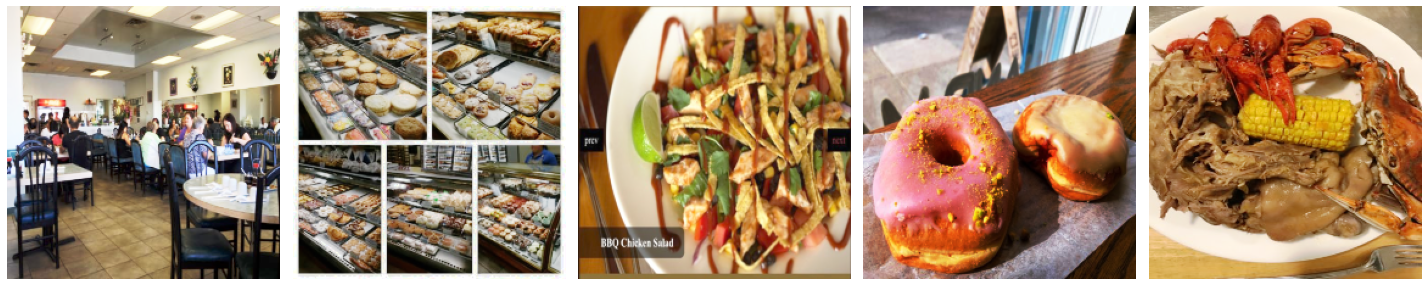

In [657]:
sample_training_images, _ = next(test_generator)
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])

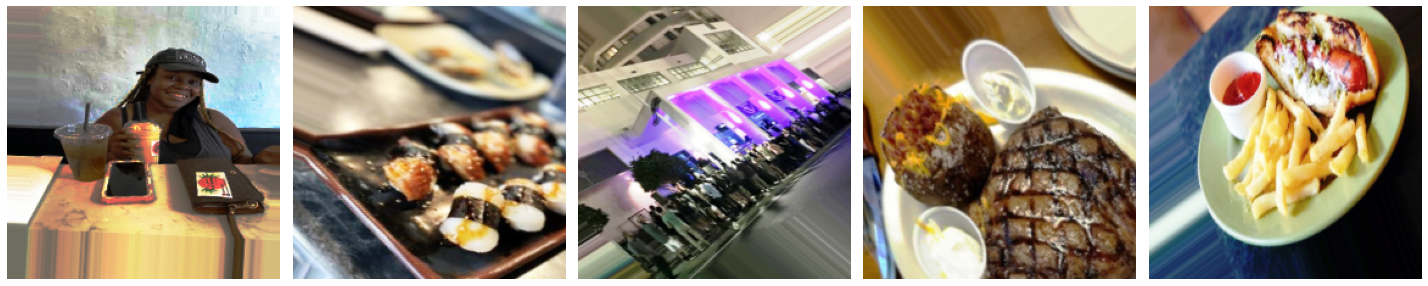

In [672]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

In [492]:
history = model.fit(train_generator, 
                              steps_per_epoch=3, 
                              epochs=100,
                              validation_data=test_generator, 
                              validation_steps=3, 
                              verbose=1)

Epoch 1/100
3/3 [==============================] - 5s 2s/step - loss: -544.4547 - accuracy: 0.5857
Epoch 2/100
3/3 [==============================] - 5s 1s/step - loss: -552.5325 - accuracy: 0.5857
Epoch 3/100
3/3 [==============================] - 5s 2s/step - loss: -580.4526 - accuracy: 0.5857
Epoch 4/100
3/3 [==============================] - 5s 2s/step - loss: -565.8082 - accuracy: 0.5857
Epoch 5/100
3/3 [==============================] - 5s 2s/step - loss: -579.1383 - accuracy: 0.5857
Epoch 6/100
3/3 [==============================] - 5s 2s/step - loss: -589.4844 - accuracy: 0.5857
Epoch 7/100
3/3 [==============================] - 6s 2s/step - loss: -595.2134 - accuracy: 0.5857
Epoch 8/100
3/3 [==============================] - 5s 1s/step - loss: -618.1330 - accuracy: 0.5857
Epoch 9/100
3/3 [==============================] - 6s 2s/step - loss: -625.4368 - accuracy: 0.5857
Epoch 10/100
3/3 [==============================] - 5s 2s/step - loss: -634.3977 - accuracy: 0.5857
Epoch 11/

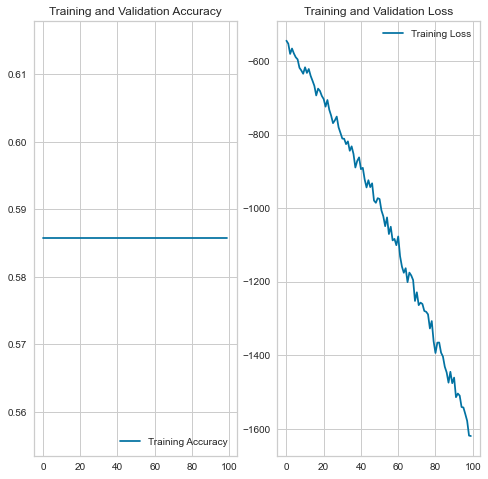

In [497]:
acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs_range = range(100) # epochs
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [113]:
import keras
from keras.utils.all_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator

In [114]:

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()


In [120]:
balanced_gen = BalancedDataGenerator(x_train, y_train, train_datagen, batch_size=32)
steps_per_epoch = balanced_gen.steps_per_epoch

In [122]:
gc.collect()

7

In [124]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc')
      #keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

In [125]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=(224,224,3)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=METRICS)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 100352)            23587712  
                                                                 
 dense_3 (Dense)             (None, 512)               51380736  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 75,231,617
Trainable params: 51,643,905


In [127]:
history = model.fit(balanced_gen, 
                    steps_per_epoch = steps_per_epoch, 
                    epochs=100,
                    validation_data=test_generator, 
                    batch_size = 56,
                    # validation_steps=3, 
                    verbose=1)

Epoch 1/100
117/117 [==============================] - 1295s 11s/step - loss: -901023.1875 - accuracy: 0.1993 - auc: 0.5000 - val_loss: -1308187.7500 - val_accuracy: 0.5267 - val_auc: 0.5000
Epoch 2/100
117/117 [==============================] - 322s 3s/step - loss: -8016631.0000 - accuracy: 0.2001 - auc: 0.5000 - val_loss: -6885165.0000 - val_accuracy: 0.5267 - val_auc: 0.5000
Epoch 3/100
117/117 [==============================] - 328s 3s/step - loss: -27905474.0000 - accuracy: 0.1998 - auc: 0.5000 - val_loss: -19539384.0000 - val_accuracy: 0.5267 - val_auc: 0.5000
Epoch 4/100
117/117 [==============================] - 323s 3s/step - loss: -65790744.0000 - accuracy: 0.2006 - auc: 0.5000 - val_loss: -41810908.0000 - val_accuracy: 0.5267 - val_auc: 0.5000
Epoch 5/100
117/117 [==============================] - 322s 3s/step - loss: -127296944.0000 - accuracy: 0.2006 - auc: 0.5000 - val_loss: -76286168.0000 - val_accuracy: 0.5267 - val_auc: 0.5000
Epoch 6/100
117/117 [=====================

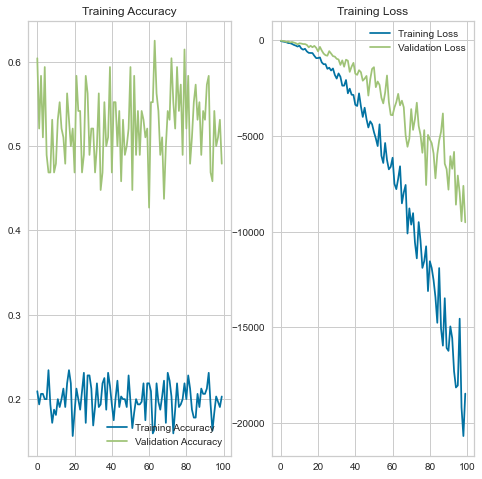

In [764]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(100) # epochs
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [702]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [718]:
processed_image = preprocess_input(X_keras_2.copy()) 

In [719]:
predictions = model.predict(processed_image) 

In [722]:
data['preds'] = predictions

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(data["label_num"] , data['preds'] )

In [723]:
data.head(2)

photo_id             business_id  \
0     zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1     HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2     vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3     pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4     H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   
...                      ...                     ...   
1995  TSL_YzQdRyOPO63g8Hg4CQ  3aY8m5w6UnxXbRMhEUPUMg   
1996  WuIwk7gQzPQ9WyOqZrOgKA  mP71DEtW0lCr75eh5ZcN6Q   
1997  Vn3odmhe8sTjmm8xoAMWUg  FMLrzIBYlEB70KjwTMQMEw   
1998  a-vSk74chVVi6cs1nSqJKw  58mmFQ8vSPKMbd7J7aUJuQ   
1999  xCgcPua0xVXXNji_OcGYgw  O9vBnoQFKLm8LdiA2YBCWw   

                                                caption    label  \
0     Nice rock artwork everywhere and craploads of ...   inside   
1                                                        outside   
2                                        oyster shooter    drink   
3                                         Shrimp scampi     food   
4                                                           food   
...                                                 ...      ...   
1995                                                      inside   
1996                              Our popular Kale Chop     food   
1997                                                        food   
1998                                                        food   
1999                 Great place for birthday parties !   inside   

                                                  photo  \
0     input\yelp_photos\photos\zsvj7vloL4L5jhYyPIuVw...   
1     input\yelp_photos\photos\HCUdRJHHm_e0OCTlZetGL...   
2     input\yelp_photos\photos\vkr8T0scuJmGVvN2HJelE...   
3     input\yelp_photos\photos\pve7D6NUrafHW3EAORuby...   
4     input\yelp_photos\photos\H52Er-uBg6rNrHcReWTD2...   
...                                                 ...   
1995  input\yelp_photos\photos\TSL_YzQdRyOPO63g8Hg4C...   
1996  input\yelp_photos\photos\WuIwk7gQzPQ9WyOqZrOgK...   
1997  input\yelp_photos\photos\Vn3odmhe8sTjmm8xoAMWU...   
1998  input\yelp_photos\photos\a-vSk74chVVi6cs1nSqJK...   
1999  input\yelp_photos\photos\xCgcPua0xVXXNji_OcGYg...   

                                    img_corrected_float  label_num  preds  
0     [[[0.43349215, 0.2857065, 0.06813415], [0.4334...          2    1.0  
1     [[[0.70247084, 0.78909767, 0.8848647], [0.6254...          4    1.0  
2     [[[0.75459146, 0.49546084, 0.58285683], [0.765...          0    1.0  
3     [[[0.08537602, 0.072888866, 0.07682341], [0.08...          1    1.0  
4     [[[0.24846414, 0.28083026, 0.33519202], [0.259...          1    1.0  
...                                                 ...        ...    ...  
1995  [[[0.08093924, 0.08093924, 0.08093924], [0.056...          2    1.0  
1996  [[[0.7738756, 0.68076533, 0.68076533], [0.7816...          1    1.0  
1997  [[[0.24276038, 0.19950387, 0.1846888], [0.2431...          1    1.0  
1998  [[[0.21475418, 0.15201613, 0.08108749], [0.210...          1    1.0  
1999  [[[0.37324548, 0.16669846, 0.13485879], [0.384...          2    1.0  

[1999 rows x 8 columns]

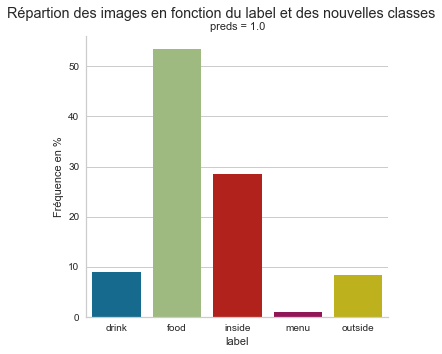

In [724]:
t = pd.crosstab(data["label"], data["preds"], normalize = "columns")
t = t.assign(label = t.index)
tm = pd.melt(t, id_vars = "label")
tm = tm.assign(value = 100 * tm.value)

ax=sns.catplot(x="label", y = "value", col = "preds", data = tm, kind = "bar")
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle("Répartion des images en fonction du label et des nouvelles classes")
ax.set_axis_labels("label","Fréquence en %")
plt.show()

In [725]:
gc.collect()

252

In [706]:
print(predictions.shape)

(600, 1)


In [705]:
from sklearn.metrics import classification_report,confusion_matrix

In [710]:
labels = data["label"].unique()

In [711]:
print(classification_report(y_test, predictions, target_names = labels))

              precision    recall  f1-score   support

      inside       0.00      0.00      0.00        57
     outside       0.53      1.00      0.69       316
       drink       0.00      0.00      0.00       174
        food       0.00      0.00      0.00         8
        menu       0.00      0.00      0.00        45

    accuracy                           0.53       600
   macro avg       0.11      0.20      0.14       600
weighted avg       0.28      0.53      0.36       600



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [712]:
predictions

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [ ]:
y_hats2 = model.predict(X)

df['y_hats'] = y_hats2

In [ ]:
from tensorflow.keras.applications.resnet50 import decode_predictions

predictionLabel = decode_predictions(prediction, top = 1)
predictionLabel

In [ ]:
predictionLabel[0][0]

In [674]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

# false pour supprbimer la dernière couche uqi sert de classification
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

model = Sequential()
model.add(restnet)
# model.add(Dense(512, activation='relu', input_dim=(224,224,3)))
# model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [683]:
gc.collect()

11148

In [686]:
history = model.fit(train_generator, 
                              steps_per_epoch=10, 
                              epochs=1000,
                              validation_data=test_generator, 
                              #validation_steps=50, 
                              shuffle         = True,
                              verbose=1,
                              batch_size=52)

Epoch 1/1000
10/10 [==============================] - 58s 6s/step - loss: -1311.3170 - accuracy: 0.5281 - val_loss: -1541.6848 - val_accuracy: 0.5267
Epoch 2/1000
10/10 [==============================] - 55s 6s/step - loss: -1597.9742 - accuracy: 0.5402 - val_loss: -1560.0802 - val_accuracy: 0.5267
Epoch 3/1000
10/10 [==============================] - 55s 6s/step - loss: -1922.7477 - accuracy: 0.5188 - val_loss: -1580.3762 - val_accuracy: 0.5267
Epoch 4/1000
10/10 [==============================] - 55s 6s/step - loss: -1771.2035 - accuracy: 0.5156 - val_loss: -1598.3706 - val_accuracy: 0.5267
Epoch 5/1000
10/10 [==============================] - 55s 6s/step - loss: -1628.1852 - accuracy: 0.5437 - val_loss: -1616.2880 - val_accuracy: 0.5267
Epoch 6/1000
10/10 [==============================] - 55s 6s/step - loss: -1701.6008 - accuracy: 0.5312 - val_loss: -1634.7305 - val_accuracy: 0.5267
Epoch 7/1000
10/10 [==============================] - 54s 6s/step - loss: -1909.3215 - accuracy: 0.5

In [675]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


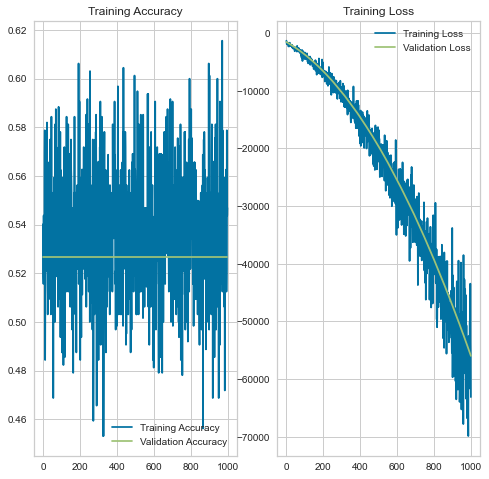

In [688]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1000) # epochs
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [563]:
gc.collect()

43127